In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import tqdm
np.set_printoptions(precision=4)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from einops import rearrange, reduce
import pytorch_warmup as warmup

from gpt_adaln_no_autoreg import Transformer
# from gpt_core import Transformer, EMA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [2]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.    , -0.0216]), array([0.2625, 0.3031]))

In [3]:
class ImitationDataset(Dataset):
    def __init__(self, states, actions, next_states, pos, num_agents, rewards, done):
        self.states = states
        self.actions = actions
        self.next_states = next_states
        self.pos = pos
        self.num_agents = num_agents
        self.rewards = rewards
        self.done = done

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        next_states = self.next_states[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        reward = self.rewards[idx]
        done = self.done[idx]
        return state, action, next_states, pos, reward, done, num_agents

def get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples:int=None):
    """ If num_samples, return a smaller dataset divided equally amnong multiple objects """
    if num_samples is None:
        return ImitationDataset(states, actions, next_states, pos, num_agents, rewards, done)
        
    chosen_indices = np.random.choice(np.arange(len(states)), num_samples, replace=False)
    final_indices = np.array(chosen_indices)

    smol_states = states[final_indices]
    smol_actions = actions[final_indices]
    smol_next_states = next_states[final_indices]
    smol_pos = pos[final_indices]
    smol_num_agents = num_agents[final_indices]
    smol_rewards = rewards[final_indices]
    smol_done = done[final_indices]
    return ImitationDataset(smol_states, smol_actions, smol_next_states, smol_pos, smol_num_agents, smol_rewards, smol_done)

def get_dataset_and_dataloaders(train_bs:int=128, val_bs:int=128, test_bs:int=1, num_samples:int=1000, rb_path='../../data/replay_buffer.pkl'):
    replay_buffer = pkl.load(open(rb_path, 'rb'))

    rewards = replay_buffer['rew']
    idxs1 = np.where(rewards > -20)[0]
    idxs2 = np.where(rewards != 0)[0]
    idxs = np.intersect1d(idxs1, idxs2)

    states = replay_buffer['obs'][idxs]
    actions = replay_buffer['act'][idxs]
    next_states = replay_buffer['obs2'][idxs]
    pos = replay_buffer['pos'][idxs]
    num_agents = replay_buffer['num_agents'][idxs]
    rewards = replay_buffer['rew'][idxs]
    done = replay_buffer['done'][idxs]
    
    dataset = get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples=num_samples)

    train_size = 0.7
    val_size = 0.15
    test_size = 0.15
    train_indices, temp_indices = train_test_split(list(range(len(dataset))), test_size=(val_size + test_size))
    val_indices, test_indices = train_test_split(temp_indices, test_size=(test_size / (test_size + val_size)))

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False)
    return train_loader, val_loader, test_loader

In [4]:
num_samples = 5000
train_loader, val_loader, test_loader = get_dataset_and_dataloaders(train_bs=128, val_bs=128, test_bs=1, num_samples=num_samples, rb_path='../../data/new_replay_buffer.pkl')

In [5]:
len(train_loader), len(val_loader), len(test_loader)

(28, 6, 750)

In [6]:
# print(state_scaler.scaler.mean_, state_scaler.scaler.var_, action_scaler.scaler.mean_, action_scaler.scaler.var_, obj_name_encoder.classes_)

# dic = {'state_scaler': state_scaler, 'action_scaler': action_scaler, 'obj_name_encoder': obj_name_encoder}
# pkl.dump(dic, open('normalizer_bc.pkl', 'wb'))

In [10]:
n_epochs = 300
hp_dict = {
        "exp_name"          : "MABC",
        "data_dir"          : "./data/rl_data",
        'warmup_iters'      : 50,
        'lr'                : 1e-4,
        'eta_min'           : 1e-6,
        'q_lr'              : 1e-4,
        'q_eta_min'         : 1e-6,
        'epochs'            : n_epochs,
        'ckpt_dir'          : './matil_expt_1.pth',
        'idx_embed_loc'     : './idx_embedding_new.pth',

        # DiT Params:
        'state_dim'         : 6,
        'action_dim'        : 2,
        'act_limit'         : 0.03,
        'gamma'             : 0.99,
        "device"            : torch.device(f"cuda:1"),
        "model_dim"         : 256,
        "num_heads"         : 8,
        "dim_ff"            : 512,
        "n_layers_dict"     : {'encoder':5, 'actor': 10, 'critic': 10},
        "dropout"           : 0,
        "max_grad_norm"     : 1,
        'gauss'             : True,
        'masked'            : True,
        'adaln'             : True,  
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR        

model = Transformer(hp_dict)
ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['device'])
# optimizer = optim.SGD(model.parameters(), lr=hp_dict['lr'])
optimizer_actor = optim.Adam(model.decoder_actor.parameters(), lr=hp_dict['lr'], weight_decay=1e-6)
optimizer_critic = optim.Adam(model.decoder_critic.parameters(), lr=hp_dict['q_lr'], weight_decay=1e-6)

# optimizer = optim.SGD(model.parameters(), lr=1e-2)
lr_scheduler_actor = CosineAnnealingWarmRestarts(optimizer_actor, T_0=20, T_mult=2, eta_min=hp_dict['eta_min'])
lr_scheduler_critic = CosineAnnealingWarmRestarts(optimizer_critic, T_0=20, T_mult=2, eta_min=hp_dict['q_eta_min'])

# ema = EMA(ema_model, **hp_dict['EMA Params'])

In [11]:
#load state dict
# model.load_state_dict(torch.load('mabc_new_data_ac_gauss.pth', weights_only=False)['model'])


In [12]:
pi_losses = []
q_losses = []
val_pi_losses = []
val_q_losses = []
global_Step = 0
start_value = 1
end_value = 1e2
steps = hp_dict['warmup_iters']

increment = (end_value - start_value) / (steps - 1)
values = [start_value + i * increment for i in range(steps)]

for param_group in optimizer_actor.param_groups:
    param_group['lr'] = hp_dict['eta_min']
for param_group in optimizer_critic.param_groups:
    param_group['lr'] = hp_dict['q_eta_min']

for epoch in range(hp_dict['epochs']):
    with tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=True, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            
            # Noised and Denoised Variable
            actions = a[:, :N].to(hp_dict['device'])

            # Conditioning Variables
            states = s1[:, :N].to(hp_dict['device'])
            next_states = s2[:, :N].to(hp_dict['device'])
            pos = p[:, :N].to(hp_dict['device'])
            rewards = r.to(hp_dict['device'])
            dones = d.to(hp_dict['device'])

            optimizer_actor.zero_grad()
            pi_loss = model.compute_actor_loss(actions, states, pos)
            pi_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer_actor.step()
            
            optimizer_critic.zero_grad()
            q_loss = model.compute_critic_loss(states, actions, next_states, pos, rewards, dones)
            q_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 100.0)
            optimizer_critic.step()

            if global_Step >= (steps-1):
                lr_scheduler_actor.step()
                lr_scheduler_critic.step()
            else:
                for param_group in optimizer_actor.param_groups:
                    param_group['lr'] = hp_dict['eta_min'] * values[global_Step]
                for param_group in optimizer_critic.param_groups:
                    param_group['lr'] = hp_dict['q_eta_min'] * values[global_Step]
                    
            # lr_scheduler.step()
            pi_losses.append(pi_loss.item())
            q_losses.append(q_loss.item())
            t.set_postfix({"pi_loss":np.mean(pi_losses[-len(train_loader):]), "q_loss":np.mean(q_losses[-len(train_loader):])}, 
                          refresh=False)
            global_Step += 1
        
        ema_model.eval()        
    
    if epoch%(n_epochs//10) == 0:
        model.eval()    
        with torch.no_grad():
            with tqdm.tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=True, mininterval=1) as v:
                for i, (s1, a, s2, p, r, d, N) in enumerate(v):
                    N = int(torch.max(N))
                    
                    # Noised and Denoised Variable
                    actions = a[:, :N].to(hp_dict['device'])
                    states = s1[:, :N].to(hp_dict['device'])
                    next_states = s2[:, :N].to(hp_dict['device'])
                    pos = p[:, :N].to(hp_dict['device'])
                    rewards = r.to(hp_dict['device'])
                    dones = d.to(hp_dict['device'])
                    

                    val_pi_loss = model.compute_actor_loss(actions, states, pos).item()
                    val_q_loss = model.compute_critic_loss(states, actions, next_states, pos, rewards, dones).item()
                    
                    val_pi_losses.append(val_pi_loss)
                    val_q_losses.append(val_q_loss)

                    v.set_postfix({"val_pi_loss":np.mean(val_pi_losses[-len(train_loader):]), "val_q_loss":np.mean(val_q_losses[-len(train_loader):])}, 
                                  refresh=False)
        model.train()

Training Epoch 299: 100%|██████████| 28/28 [00:01<00:00, 15.05it/s, pi_loss=0.000153, q_loss=3.64]


In [ ]:
# This block is to break the sequence of run alls
assert True == False

In [19]:
expt_dict = {"model": model.state_dict(), "optimizer_actor": optimizer_actor.state_dict(), "optimizer_critic": optimizer_critic.state_dict()}
torch.save(expt_dict, './mabc_final.pth')

In [13]:
train_losses_bkp = pi_losses
val_losses_bkp = val_pi_losses

# train_losses_bkp = q_losses
# val_losses_bkp = val_q_losses

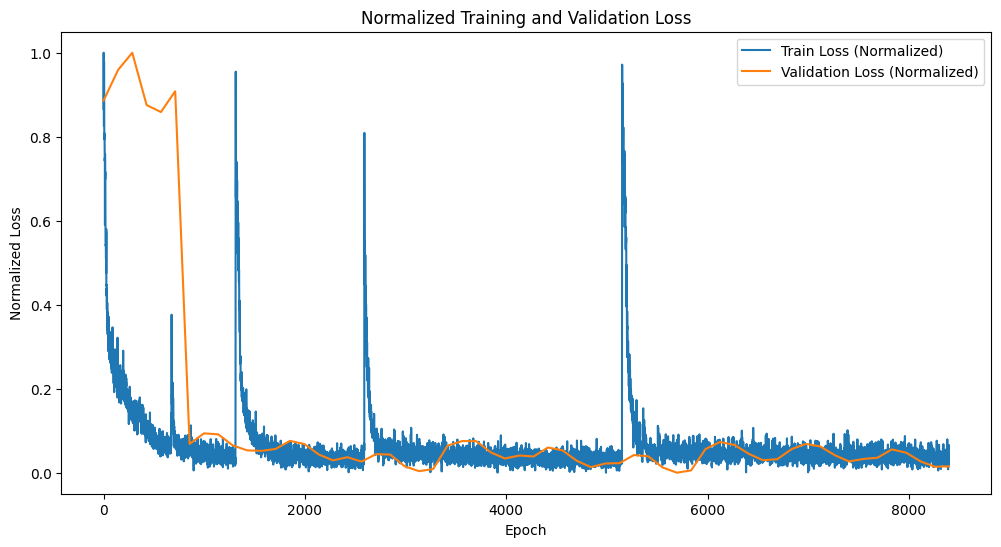

In [14]:
train_losses = np.array(train_losses_bkp[0:])
val_losses = np.array(val_losses_bkp[0:])
x_val = np.linspace(0, len(train_losses) - 1, len(val_losses))
x_train = np.arange(len(train_losses))
val_losses_interpolated = np.interp(x_train, x_val, val_losses)

# Step 2: Normalization of both losses
scaler = MinMaxScaler()


# combined_losses = np.concatenate((loss_train, loss_val_interpolated)).reshape(-1, 1)
# scaler.fit(combined_losses)

# Reshape for sklearn which expects 2D array
train_losses_normalized = scaler.fit_transform(train_losses.reshape(-1, 1)).flatten()
val_losses_normalized = scaler.fit_transform(val_losses_interpolated.reshape(-1, 1)).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses_normalized, label='Train Loss (Normalized)')
plt.plot(val_losses_normalized, label='Validation Loss (Normalized)')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Normalized Training and Validation Loss')
# plt.ylim(0, 0.05)
plt.legend()
plt.show()

In [15]:
# _, _, test_loader = get_dataset_and_dataloaders(train_bs=128, test_bs=1, num_samples=4000, obj_of_interest=None, rb_path='../../data/new_replay_buffer.pkl')

In [16]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import time

model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []
n_agents = []

grand_data = np.zeros((100, 128, 10, 2))
with torch.no_grad():
    with tqdm.tqdm(test_loader, desc=f"Validation", leave=False, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            n_agents.append(N)
            
            actions = a[:1, :N].to(hp_dict['device'])
            actions_gt.append(actions)

            # Conditioning Variables
            states = s1[:1, :N].to(hp_dict['device'])
            statesss.append(states)
            next_states = s2[:, :N].to(hp_dict['device'])
            # print(actions, states)
            pos = p[:1, :N].to(hp_dict['device'])
            possss.append(pos)

            now = time.time()
            output_actions = model.get_actions(states, pos, deterministic=True)
            print("time in ms: ", time.time() - now)
            actionsss.append(output_actions)
            loss.append((actions[:1, :N].cpu().detach().numpy() - output_actions.cpu().detach().numpy()).mean()**2)
            
            if i>60:
                break


Validation:   0%|          | 0/750 [00:00<?, ?it/s]

time in ms:  0.005343437194824219
time in ms:  0.004461050033569336
time in ms:  0.004546403884887695
time in ms:  0.003956317901611328
time in ms:  0.0043027400970458984
time in ms:  0.004172325134277344
time in ms:  0.004058361053466797
time in ms:  0.004044771194458008
time in ms:  0.004383087158203125
time in ms:  0.004224061965942383
time in ms:  0.004563570022583008
time in ms:  0.004361867904663086
time in ms:  0.004186153411865234
time in ms:  0.004170894622802734
time in ms:  0.0041882991790771484
time in ms:  0.003993511199951172
time in ms:  0.00408625602722168
time in ms:  0.00403141975402832
time in ms:  0.00431513786315918
time in ms:  0.0045223236083984375
time in ms:  0.004283428192138672
time in ms:  0.0044384002685546875
time in ms:  0.004254817962646484
time in ms:  0.0040018558502197266
time in ms:  0.003924131393432617
time in ms:  0.004047870635986328
time in ms:  0.00433039665222168
time in ms:  0.004147768020629883
time in ms:  0.004463911056518555
time in ms:  

time in ms:  0.0047190189361572266
time in ms:  0.0042514801025390625
time in ms:  0.004129648208618164
time in ms:  0.004481077194213867
time in ms:  0.004312038421630859
time in ms:  0.004637002944946289
time in ms:  0.004359006881713867
time in ms:  0.006252288818359375
time in ms:  0.00475001335144043
time in ms:  0.004569053649902344
time in ms:  0.006175041198730469
time in ms:  0.006188631057739258
time in ms:  0.006253719329833984
time in ms:  0.0052983760833740234
time in ms:  0.0049479007720947266
time in ms:  0.004269599914550781
time in ms:  0.0040357112884521484
time in ms:  0.003935337066650391
time in ms:  0.004096031188964844
time in ms:  0.004038333892822266
time in ms:  0.00416254997253418
time in ms:  0.0041620731353759766
time in ms:  0.004290342330932617
time in ms:  0.00440216064453125
time in ms:  0.0047495365142822266
time in ms:  0.004000425338745117
time in ms:  0.00397491455078125
time in ms:  0.0040400028228759766
time in ms:  0.004277944564819336
time in ms

3.6087466236769666e-05

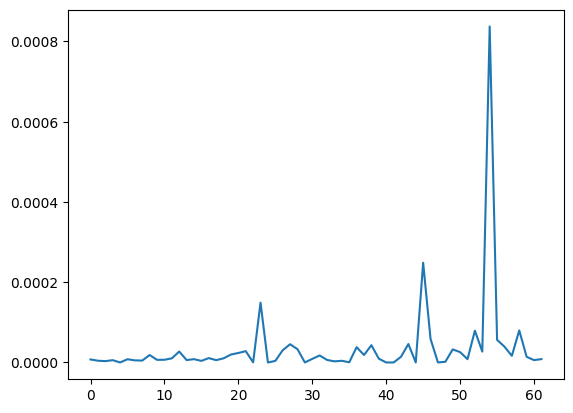

In [17]:
plt.plot(loss)
np.mean(loss)

[[-0.0262 -0.0298]
 [ 0.0295  0.0257]
 [ 0.0289 -0.0012]
 [-0.0285 -0.0285]
 [-0.018   0.0295]]
[[-0.0231 -0.0631]
 [ 0.0575  0.0386]
 [ 0.0373 -0.004 ]
 [-0.0325 -0.0356]
 [-0.0071  0.0412]]
5


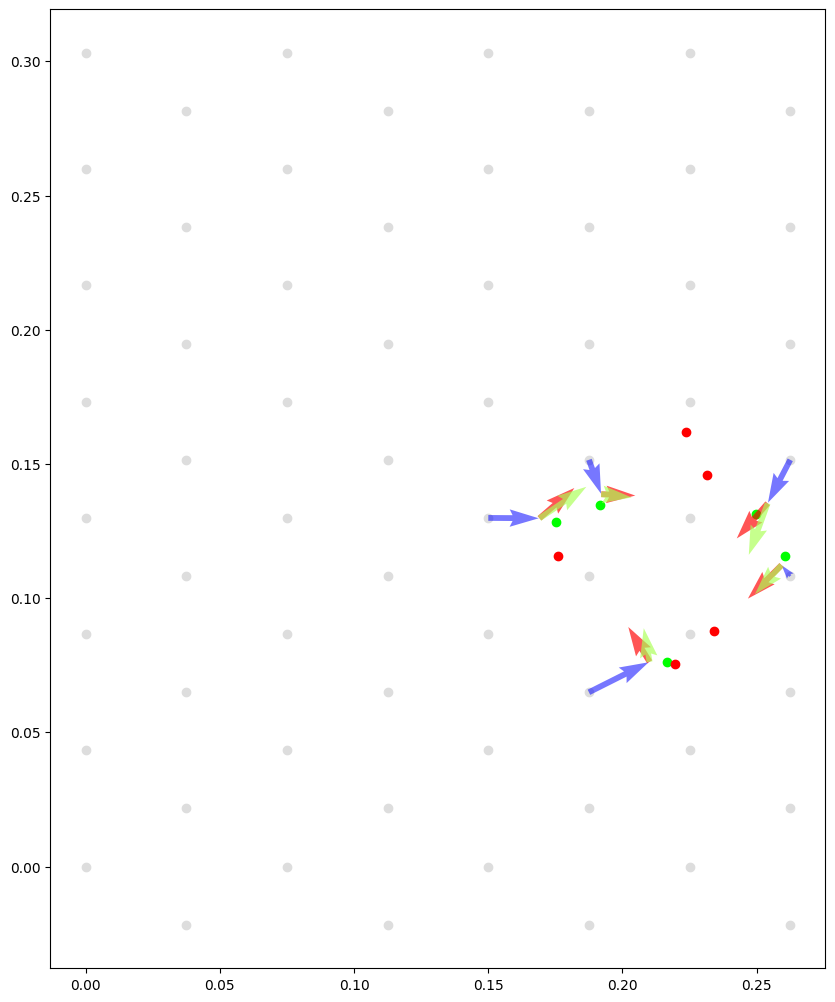

[[-0.029   0.0234]
 [-0.0251  0.0299]
 [ 0.0286  0.0195]
 [ 0.0294 -0.0282]
 [ 0.0285  0.0289]
 [-0.0233 -0.0297]
 [-0.0299 -0.0119]]
[[-0.0545  0.0166]
 [-0.0343  0.0777]
 [ 0.0462  0.0169]
 [ 0.0479 -0.0413]
 [ 0.0435  0.047 ]
 [-0.0308 -0.0543]
 [-0.0851 -0.0136]]
7


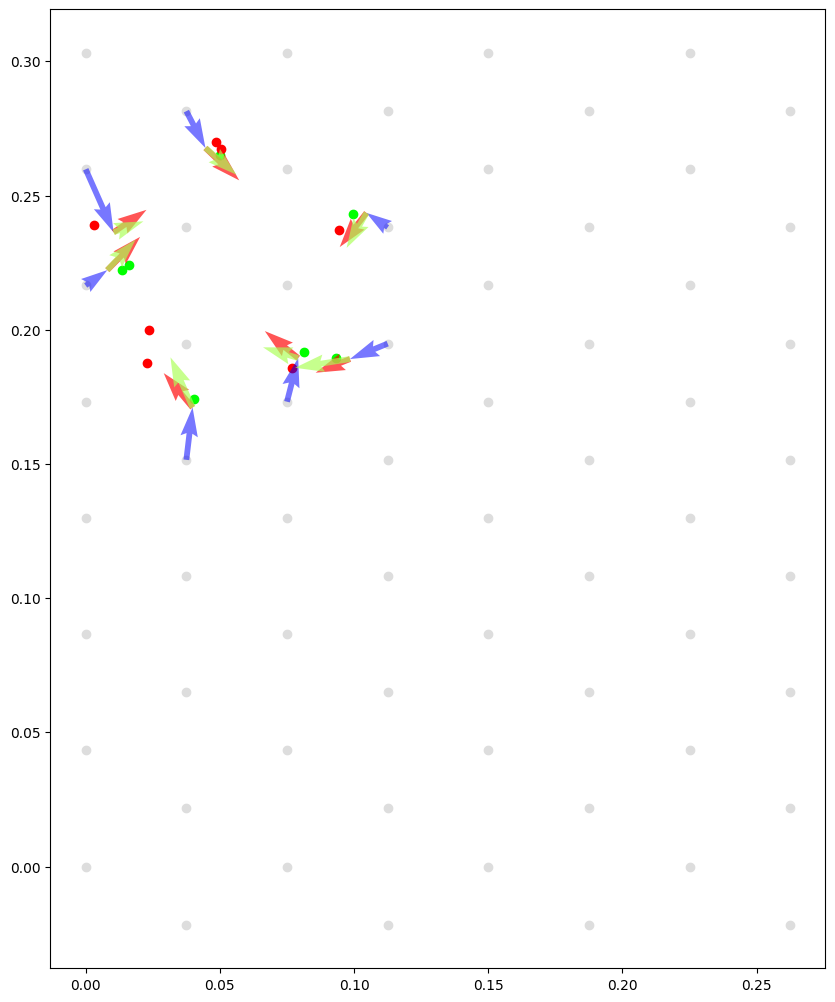

[[-0.0126 -0.0297]
 [-0.0253 -0.0195]
 [ 0.0298  0.0251]
 [ 0.0271  0.0281]
 [-0.0054  0.0279]
 [ 0.0276 -0.0277]]
[[-0.0107 -0.0561]
 [-0.0249 -0.0212]
 [ 0.0681  0.0267]
 [ 0.037   0.0368]
 [-0.0072  0.0249]
 [ 0.0311 -0.0371]]
6


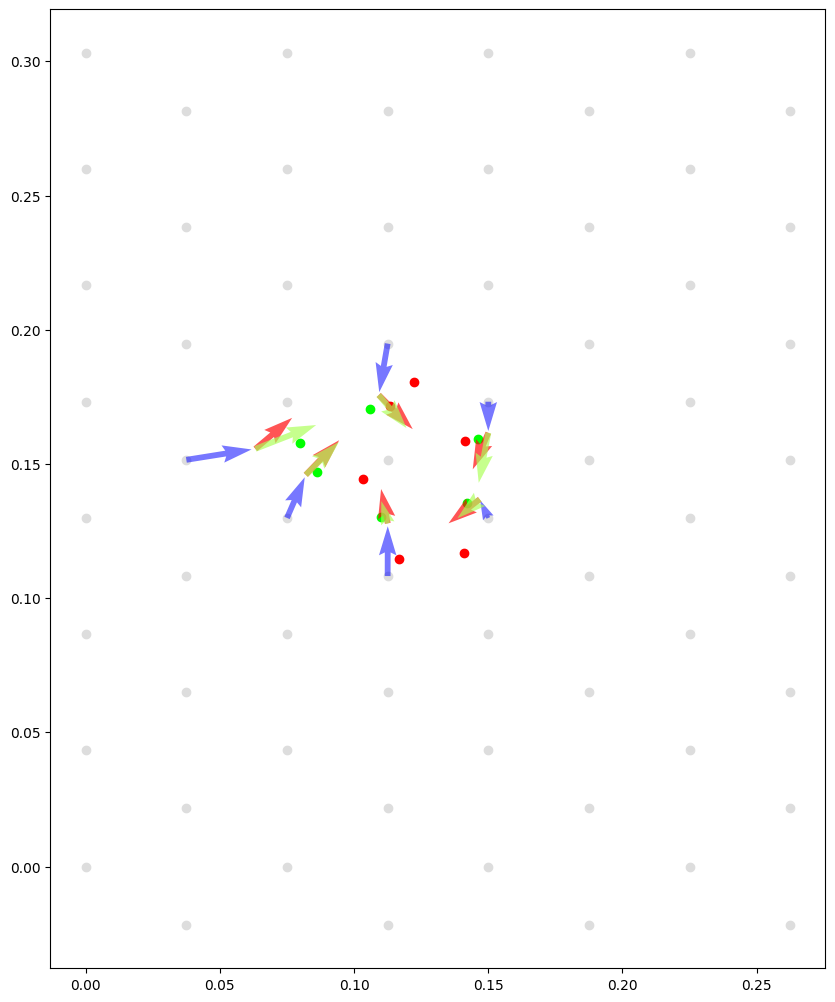

[[-0.0237 -0.0279]
 [ 0.004  -0.0122]
 [-0.027  -0.0117]
 [-0.0157  0.0229]
 [-0.008   0.0295]
 [ 0.014   0.0288]]
[[-0.0203 -0.0312]
 [-0.0029 -0.0061]
 [-0.0284 -0.0083]
 [-0.0144  0.0243]
 [-0.0087  0.0542]
 [ 0.0107  0.0329]]
6


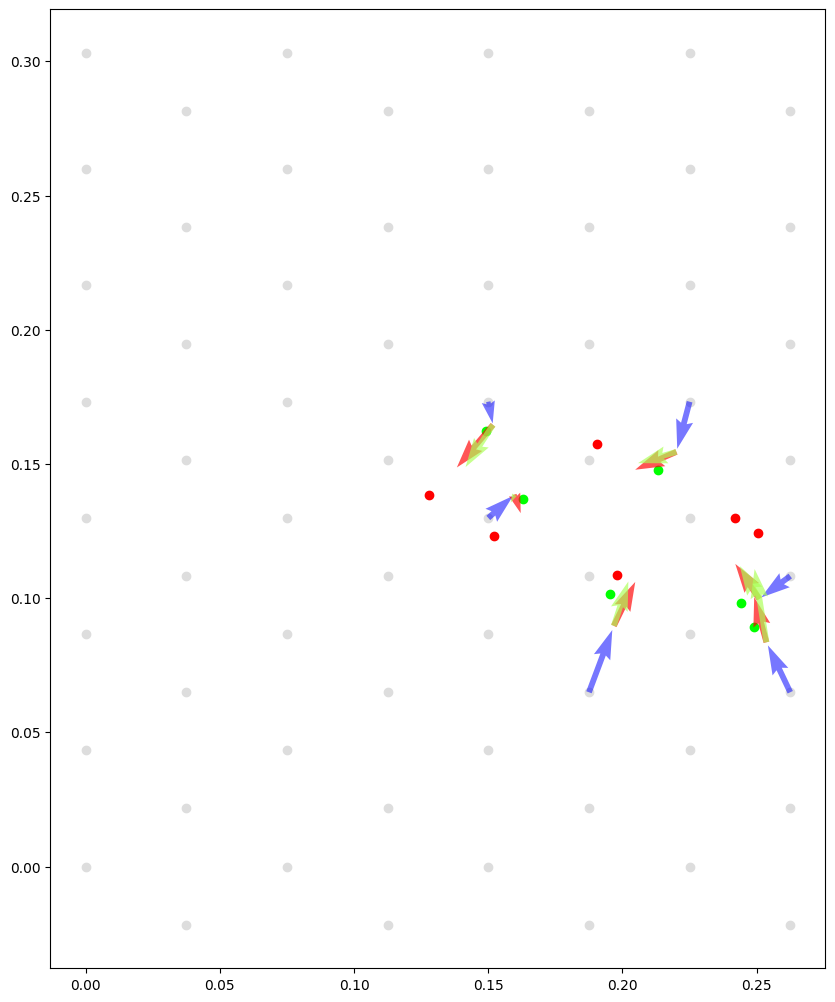

[[-0.0255  0.0192]
 [-0.0035 -0.0034]
 [ 0.0184  0.0152]
 [ 0.0219  0.0248]
 [-0.0242  0.0276]
 [-0.0092  0.0286]
 [ 0.0219  0.029 ]
 [ 0.0016  0.009 ]]
[[-0.026   0.0158]
 [-0.0044 -0.0003]
 [ 0.0107  0.0148]
 [ 0.0126  0.0271]
 [-0.0243  0.0399]
 [-0.009   0.0402]
 [ 0.0157  0.0366]
 [-0.0049  0.011 ]]
8


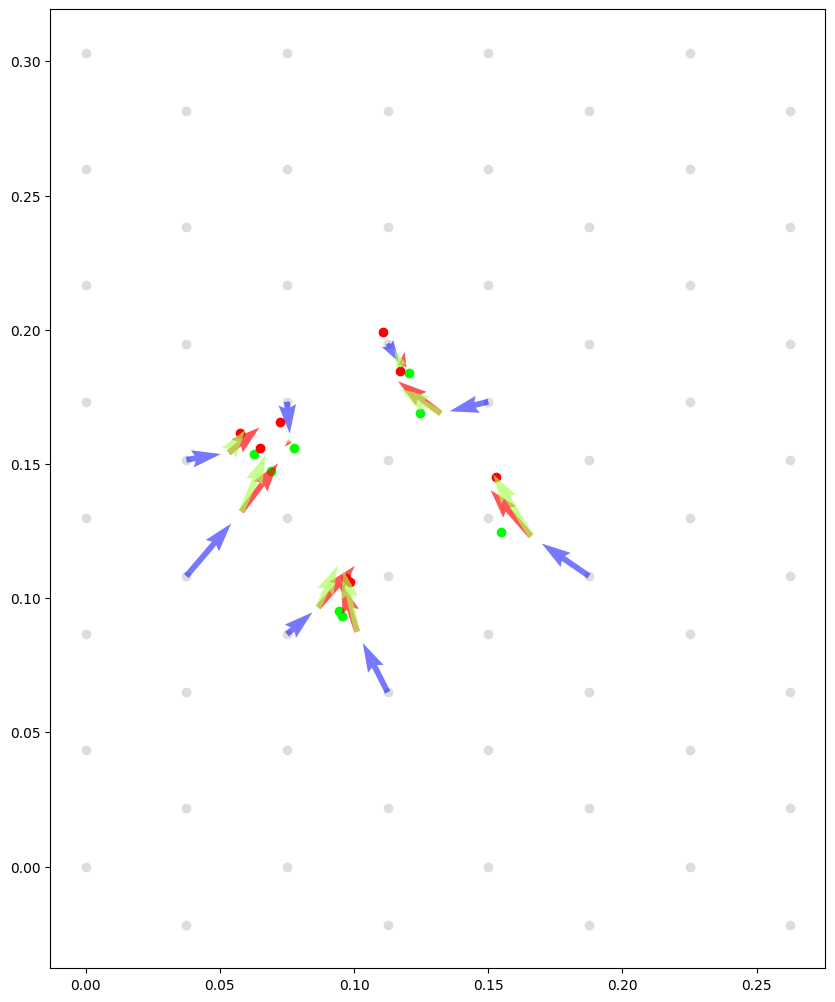

[[ 0.0232  0.0271]
 [-0.0058 -0.0133]
 [-0.0231  0.0057]
 [-0.0193  0.0266]
 [-0.0017  0.0266]]
[[ 0.033   0.0283]
 [ 0.0001 -0.0122]
 [-0.0168  0.0019]
 [-0.0135  0.0263]
 [ 0.0026  0.0243]]
5


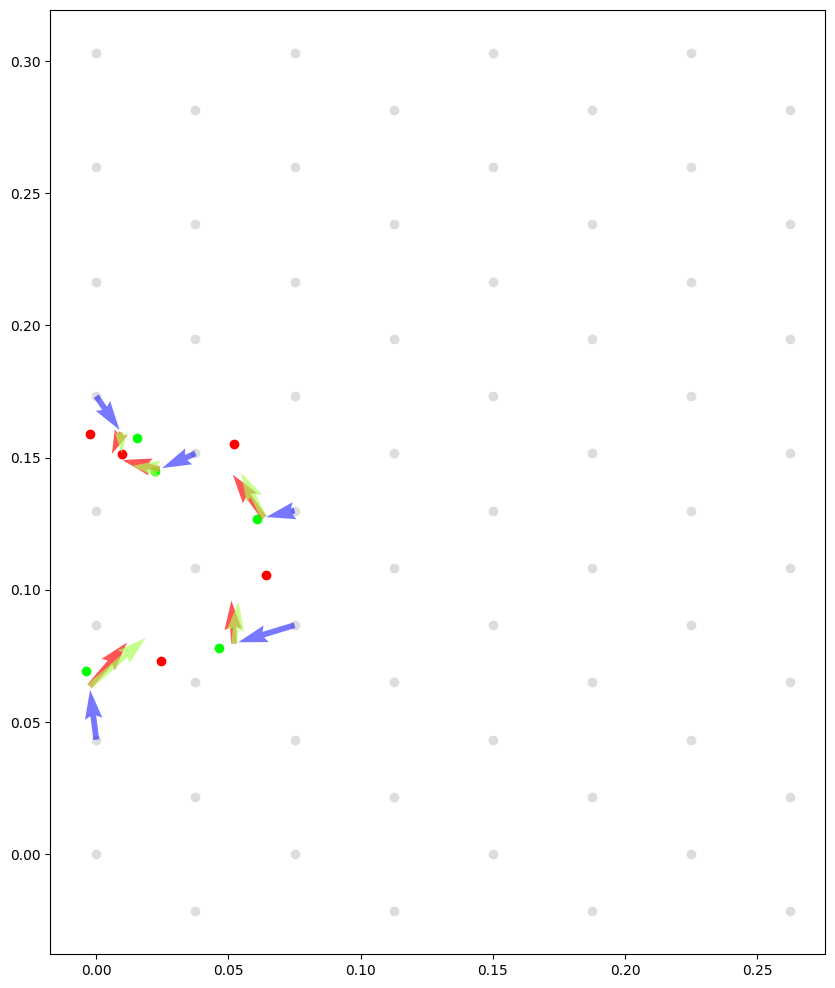

[[ 0.0285  0.0074]
 [ 0.0223  0.0065]
 [-0.001  -0.0187]
 [ 0.0266  0.0267]
 [ 0.017   0.0288]
 [-0.018   0.0285]
 [-0.0283  0.019 ]
 [-0.0297 -0.0172]]
[[ 0.0357  0.0062]
 [ 0.0146  0.0032]
 [-0.0057 -0.0173]
 [ 0.0304  0.0305]
 [ 0.0125  0.0346]
 [-0.0176  0.0342]
 [-0.0372  0.0137]
 [-0.0619 -0.0141]]
8


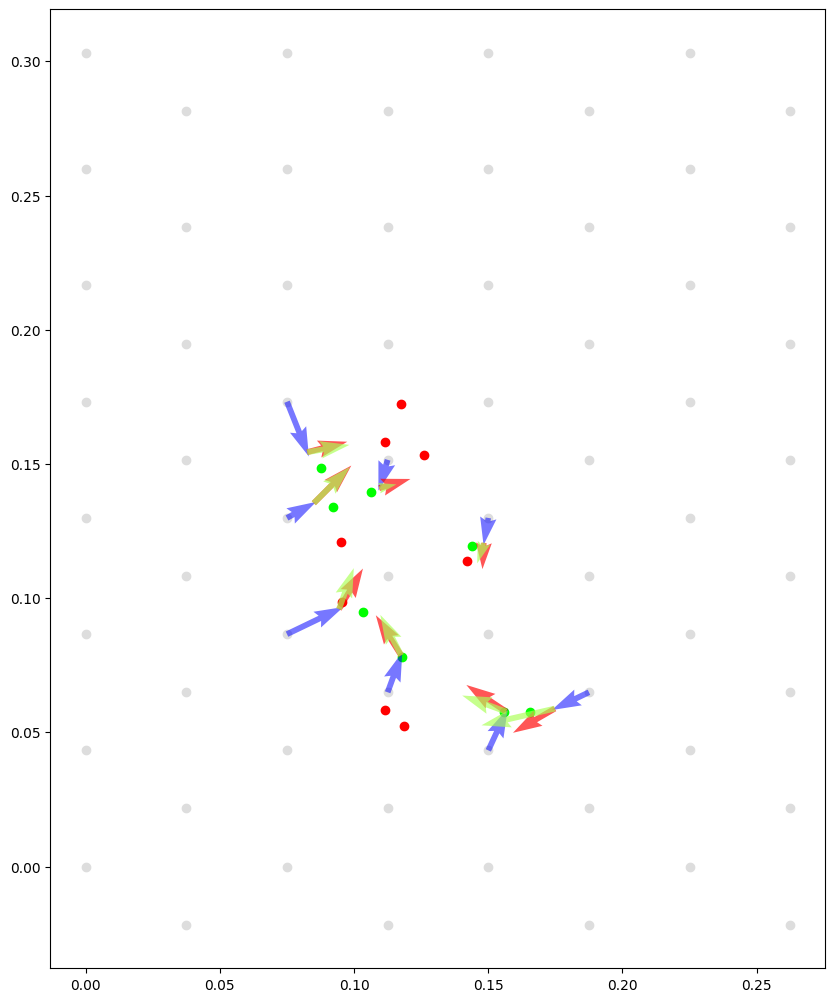

[[-0.0217 -0.0283]
 [-0.0299  0.03  ]
 [ 0.0292  0.0299]
 [ 0.0267  0.0255]
 [ 0.0273 -0.0269]]
[[-0.0252 -0.0463]
 [-0.0882  0.0083]
 [ 0.0538  0.0768]
 [ 0.0276  0.0242]
 [ 0.0338 -0.0248]]
5


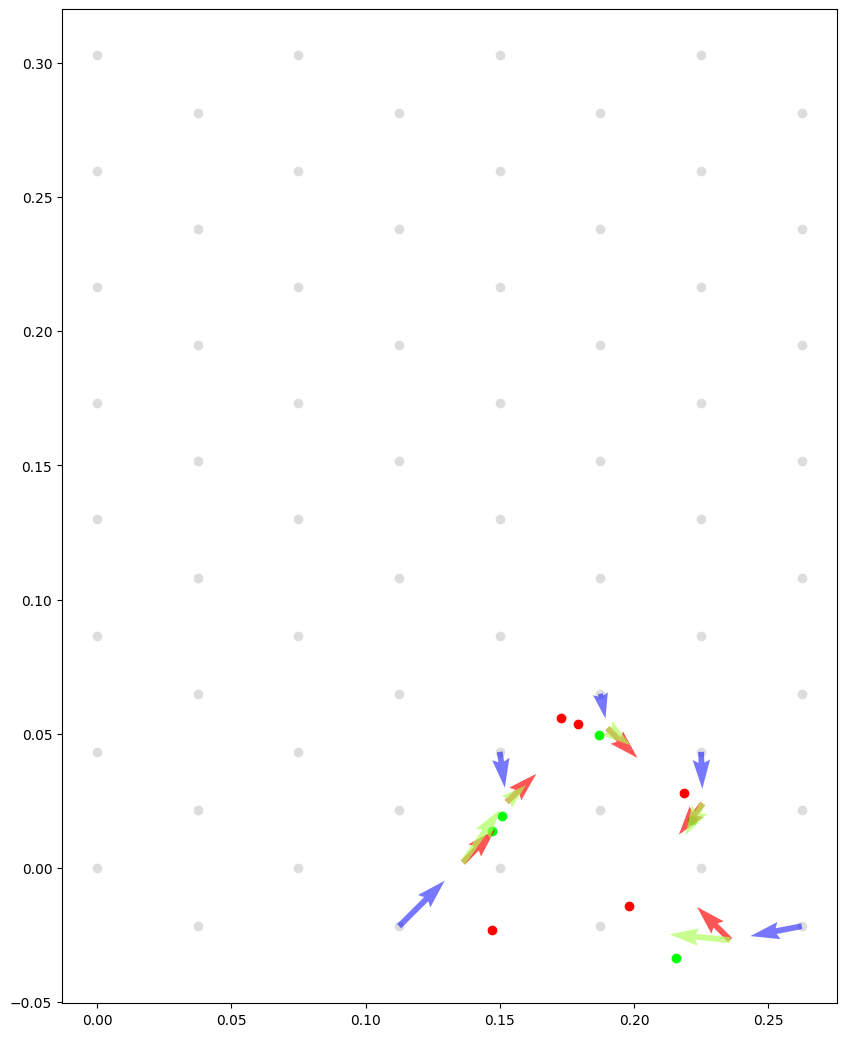

[[ 0.0207 -0.0287]
 [-0.0268  0.028 ]
 [ 0.0253  0.0259]
 [ 0.0259 -0.0066]
 [ 0.0151  0.0282]
 [-0.0242 -0.0289]
 [-0.0261 -0.0069]]
[[ 0.0151 -0.0437]
 [-0.0349  0.0308]
 [ 0.0263  0.0183]
 [ 0.0248 -0.0096]
 [ 0.008   0.0334]
 [-0.0305 -0.0397]
 [-0.0354 -0.0024]]
7


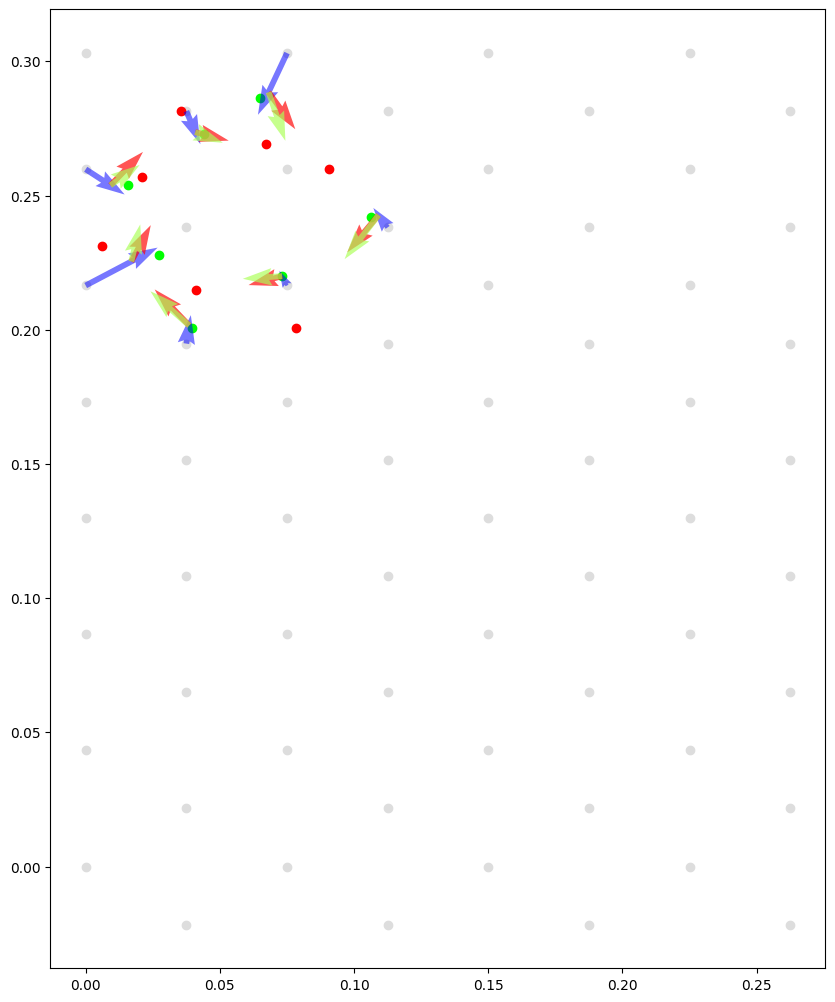

[[-0.0281 -0.0159]
 [-0.0269  0.0166]
 [ 0.0212  0.0197]
 [-0.02   -0.02  ]]
[[-0.041  -0.0076]
 [-0.0378  0.0124]
 [ 0.0127  0.0209]
 [-0.022  -0.0117]]
4


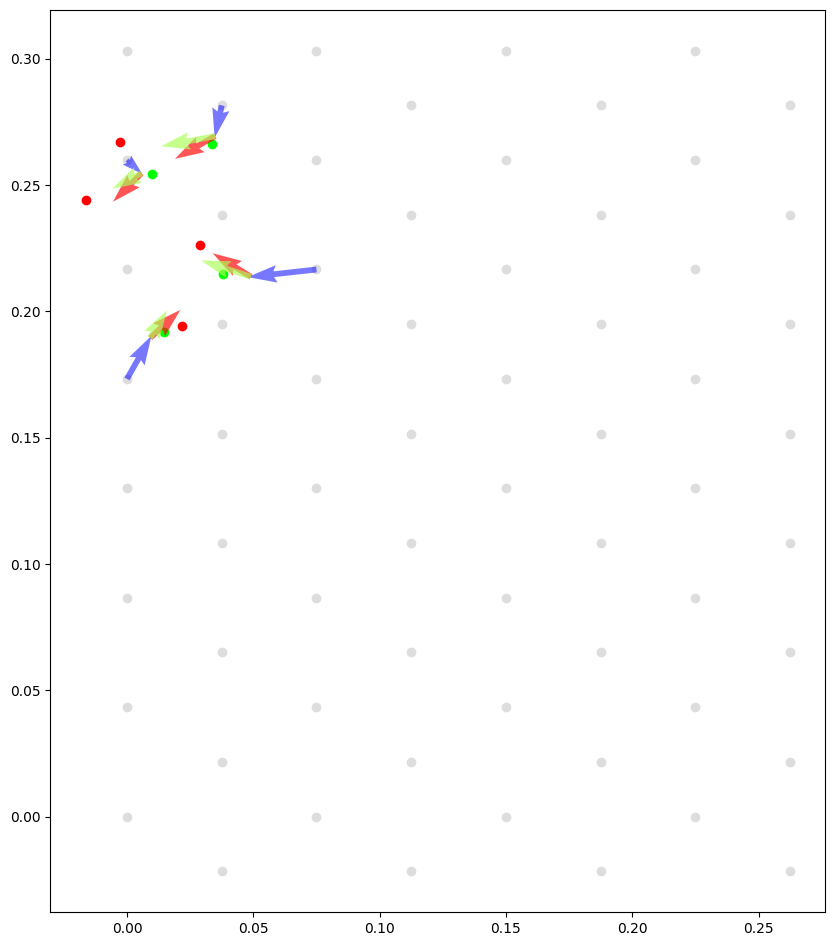

[[ 0.0228  0.0217]
 [ 0.0252 -0.0203]
 [ 0.0256  0.0275]
 [-0.0002 -0.0264]
 [ 0.0263 -0.0293]
 [-0.0145 -0.0147]
 [-0.0121  0.0238]]
[[ 0.0226  0.011 ]
 [ 0.0319 -0.0231]
 [ 0.023   0.025 ]
 [ 0.0008 -0.0318]
 [ 0.0312 -0.0587]
 [-0.0108 -0.0109]
 [-0.0117  0.0206]]
7


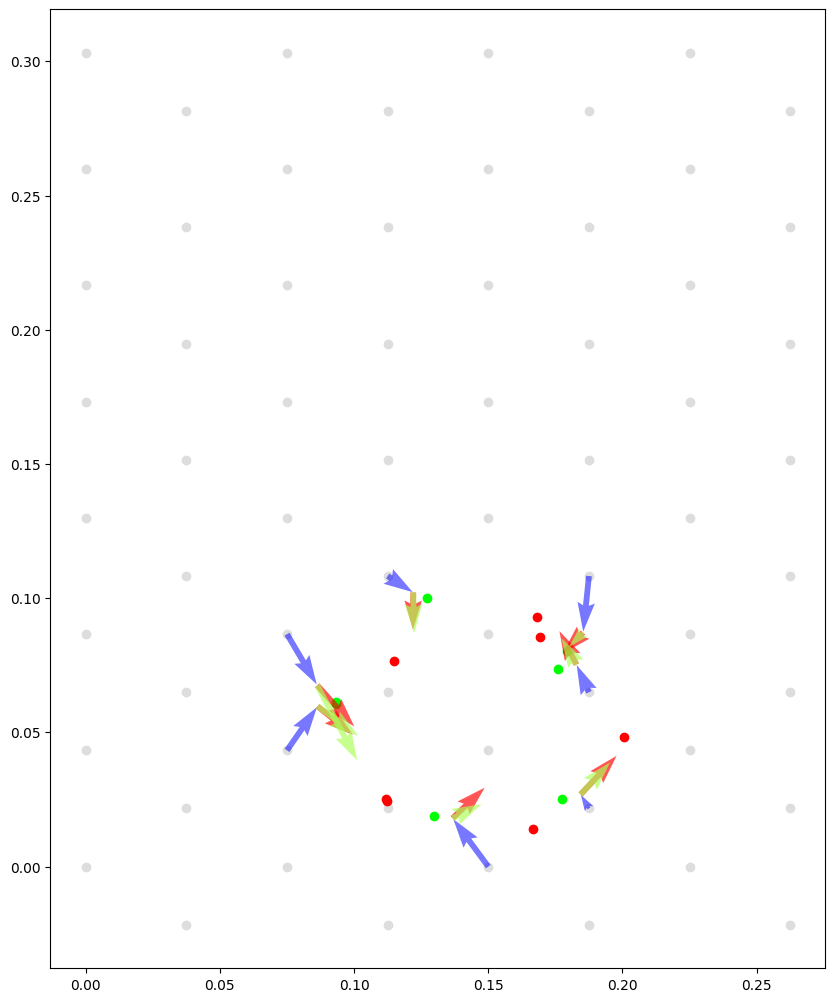

[[ 0.029   0.0238]
 [ 0.0131  0.0135]
 [ 0.0235 -0.0188]
 [ 0.0232  0.0288]
 [-0.0167  0.0286]
 [ 0.0265  0.0292]
 [ 0.0274  0.002 ]]
[[ 0.0385  0.0179]
 [ 0.0078  0.0095]
 [ 0.0176 -0.0175]
 [ 0.0226  0.0434]
 [-0.0119  0.0427]
 [ 0.0315  0.048 ]
 [ 0.0299 -0.002 ]]
7


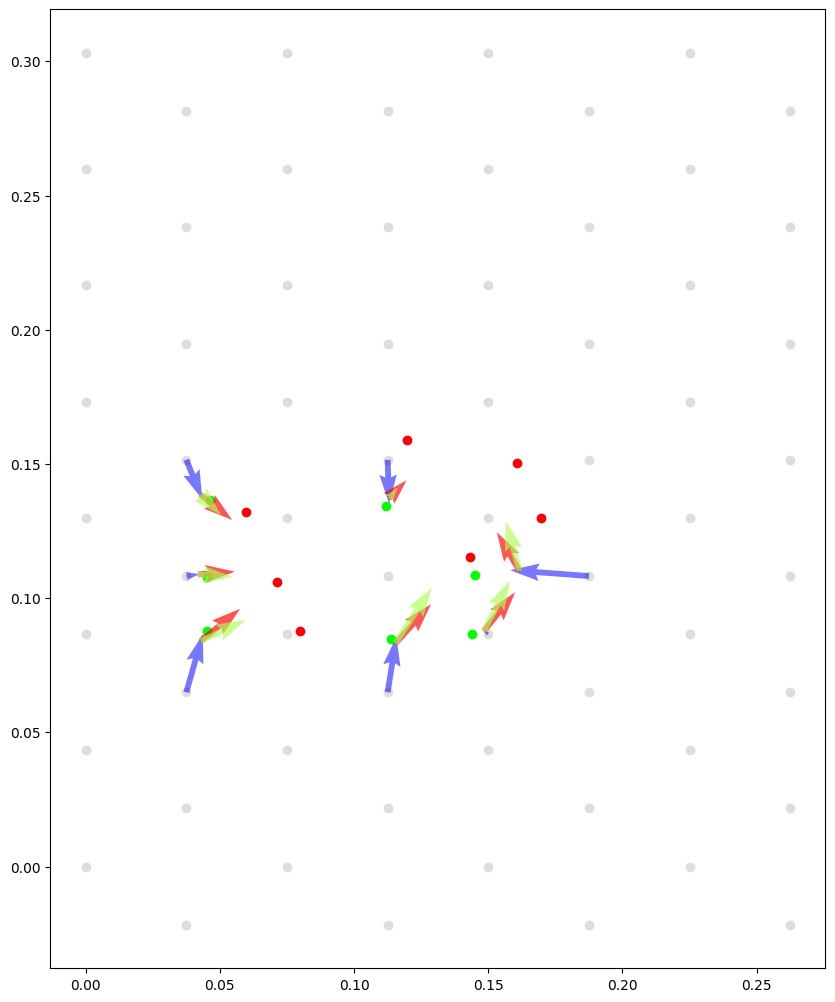

[[-0.0206 -0.0227]
 [ 0.0075  0.0099]
 [ 0.0204 -0.0292]
 [-0.0028 -0.0266]
 [-0.0162 -0.0282]]
[[-0.0231 -0.0197]
 [ 0.0049  0.0039]
 [ 0.0147 -0.0418]
 [-0.0082 -0.0361]
 [-0.0202 -0.035 ]]
5


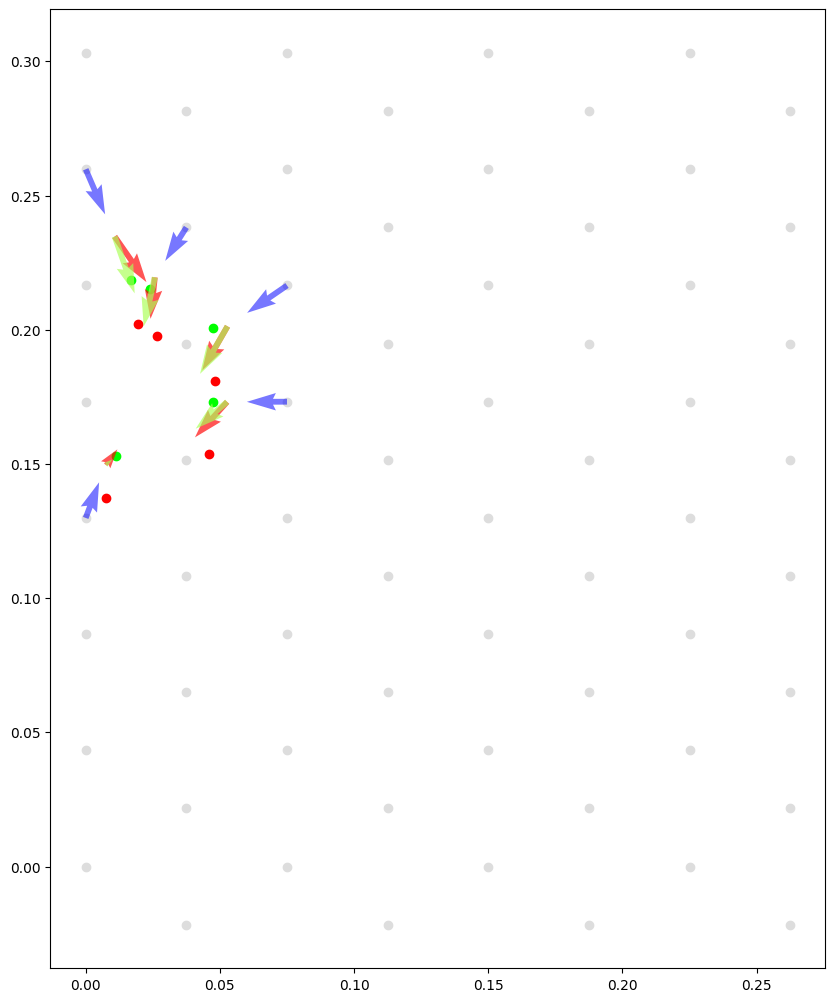

[[ 0.03   -0.0138]
 [-0.0209 -0.0299]
 [ 0.0292  0.0254]
 [ 0.0188  0.0298]
 [-0.0274 -0.0298]]
[[ 0.0893 -0.0109]
 [-0.0246 -0.0801]
 [ 0.047   0.0305]
 [ 0.0196  0.0711]
 [-0.0399 -0.0664]]
5


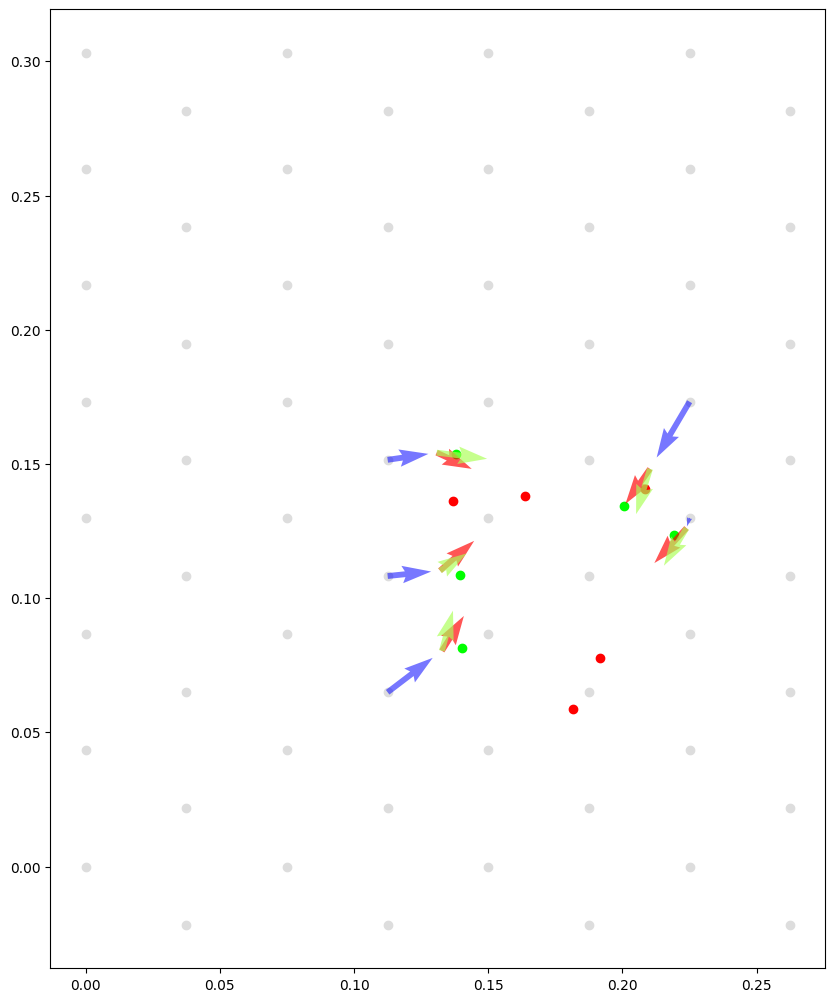

[[-0.0178 -0.0242]
 [-0.0196  0.0154]
 [-0.0169  0.0087]
 [ 0.0126 -0.0179]
 [ 0.0148 -0.0268]]
[[-0.0177 -0.023 ]
 [-0.0165  0.0077]
 [-0.0197  0.0017]
 [ 0.0085 -0.0159]
 [ 0.0084 -0.0341]]
5


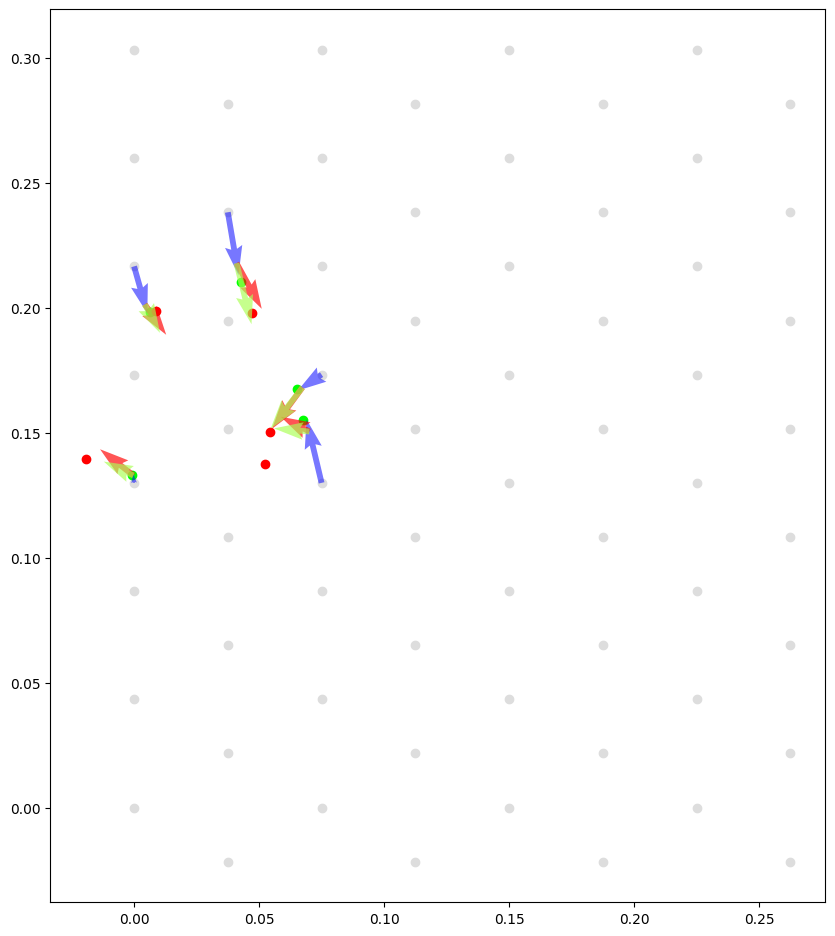

[[-0.0222  0.0244]
 [ 0.0139 -0.0289]
 [ 0.0105  0.0257]
 [ 0.0286 -0.0168]
 [ 0.0283  0.0066]
 [-0.0293 -0.0027]]
[[-0.0215  0.0152]
 [ 0.0134 -0.0415]
 [ 0.0063  0.0227]
 [ 0.0498 -0.013 ]
 [ 0.0346  0.003 ]
 [-0.0477 -0.0071]]
6


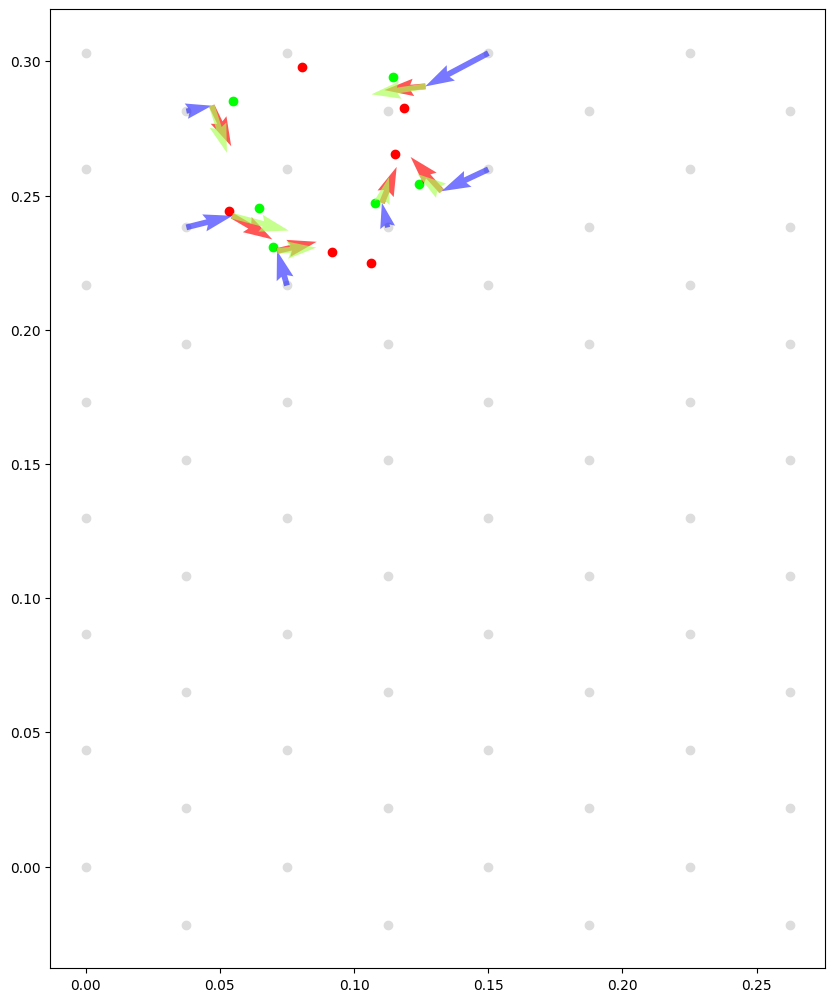

[[ 0.0201 -0.0158]
 [-0.0287  0.0261]
 [ 0.0248  0.0252]
 [-0.0272 -0.0189]
 [ 0.0272 -0.0104]
 [ 0.029   0.0059]
 [ 0.011   0.0249]
 [ 0.0287  0.0277]]
[[ 0.0203 -0.0178]
 [-0.0297  0.0228]
 [ 0.0311  0.0247]
 [-0.0239 -0.0113]
 [ 0.0383 -0.012 ]
 [ 0.0509  0.0011]
 [ 0.0101  0.0209]
 [ 0.0455  0.0316]]
8


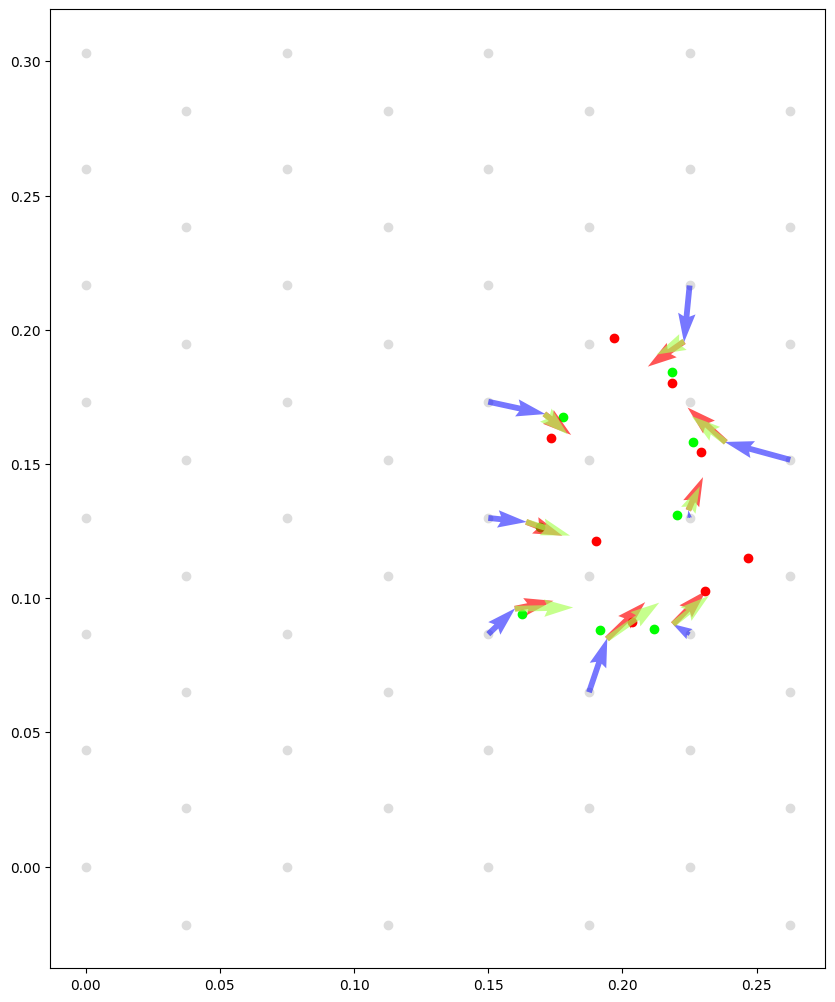

[[-0.0277  0.0111]
 [-0.0201 -0.0082]
 [-0.0153  0.0254]
 [ 0.0279 -0.0165]
 [ 0.0223 -0.0154]
 [-0.0066 -0.0288]
 [ 0.017   0.024 ]]
[[-0.0288  0.006 ]
 [-0.0146 -0.0086]
 [-0.0128  0.0213]
 [ 0.0315 -0.0223]
 [ 0.0173 -0.0084]
 [-0.0127 -0.0429]
 [ 0.0099  0.0206]]
7


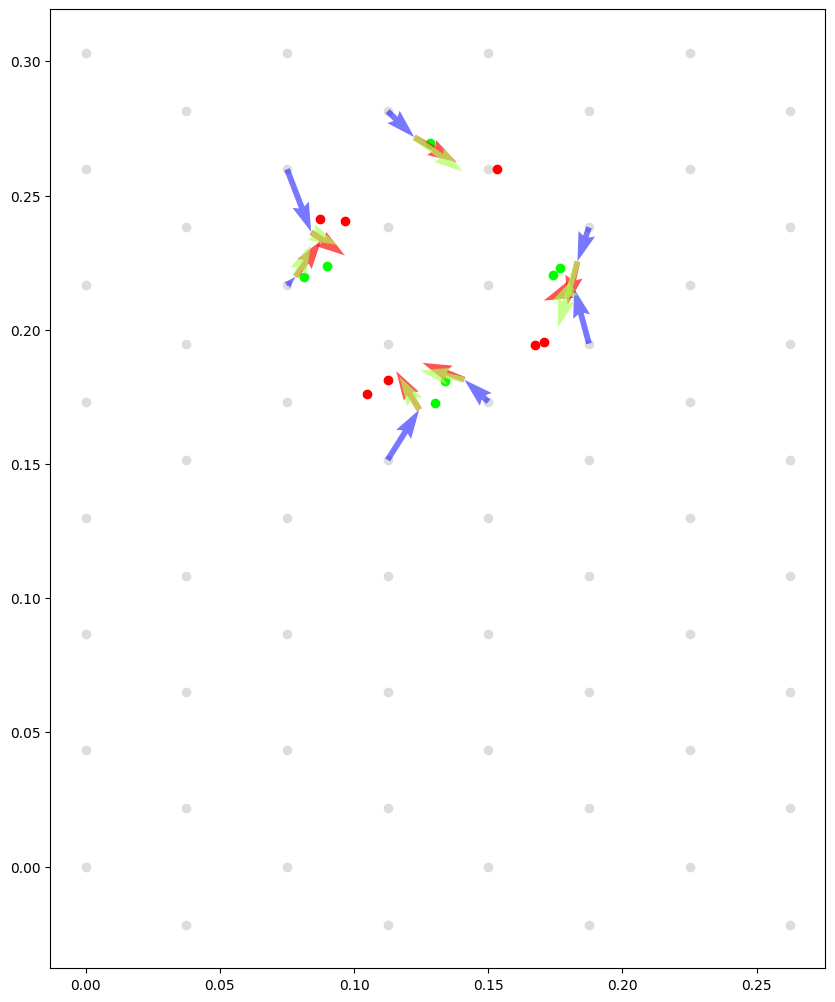

[[ 0.0246  0.0294]
 [-0.0156  0.0292]
 [ 0.0062 -0.0133]
 [ 0.004  -0.0135]
 [-0.0274  0.0291]
 [-0.0164  0.0198]
 [ 0.0206  0.0291]]
[[ 0.0173  0.0448]
 [-0.0073  0.0372]
 [ 0.0019 -0.0082]
 [ 0.0003 -0.0091]
 [-0.0302  0.0426]
 [-0.0149  0.0153]
 [ 0.0189  0.0423]]
7


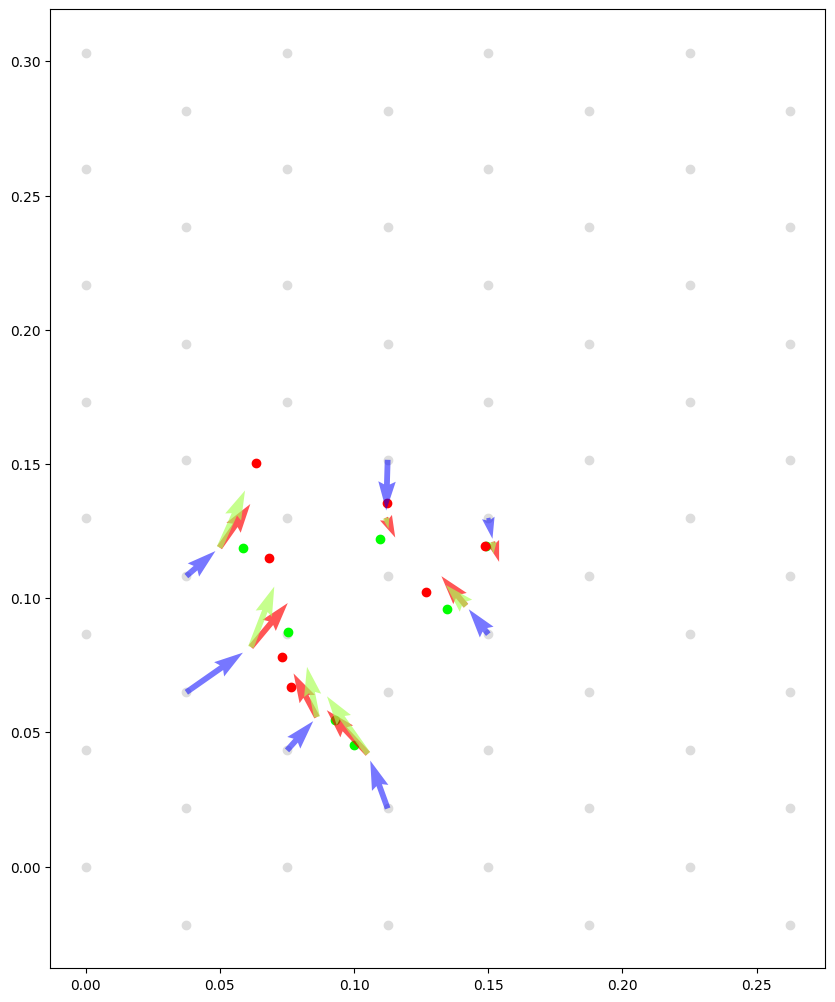

[[-1.3331e-02  1.3349e-03]
 [ 2.9286e-02  1.4367e-02]
 [ 1.8106e-02 -1.2628e-02]
 [ 1.8118e-02  2.7219e-02]
 [ 2.7372e-02  9.1617e-04]
 [ 2.8955e-02 -2.1290e-02]
 [ 1.8088e-02  1.7848e-02]
 [-1.4940e-02  9.1621e-05]]
[[-0.0039  0.0022]
 [ 0.0388  0.0161]
 [ 0.0219 -0.01  ]
 [ 0.0172  0.0331]
 [ 0.0355  0.0063]
 [ 0.0459 -0.0202]
 [ 0.0147  0.0188]
 [-0.0093  0.0037]]
8


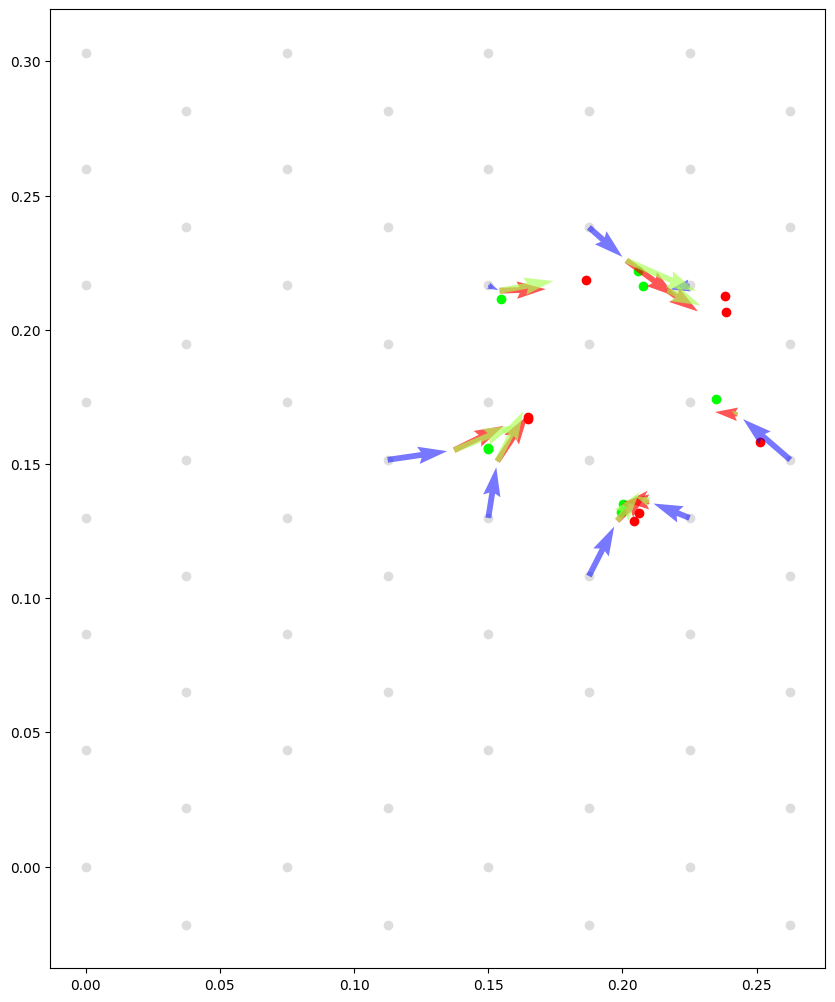

[[ 0.0257 -0.0123]
 [ 0.0171  0.0174]
 [-0.0249  0.0242]
 [-0.0171 -0.0216]
 [ 0.0152 -0.0265]]
[[ 0.019  -0.0111]
 [ 0.0185  0.0066]
 [-0.0323  0.0213]
 [-0.0196 -0.0263]
 [ 0.0052 -0.0327]]
5


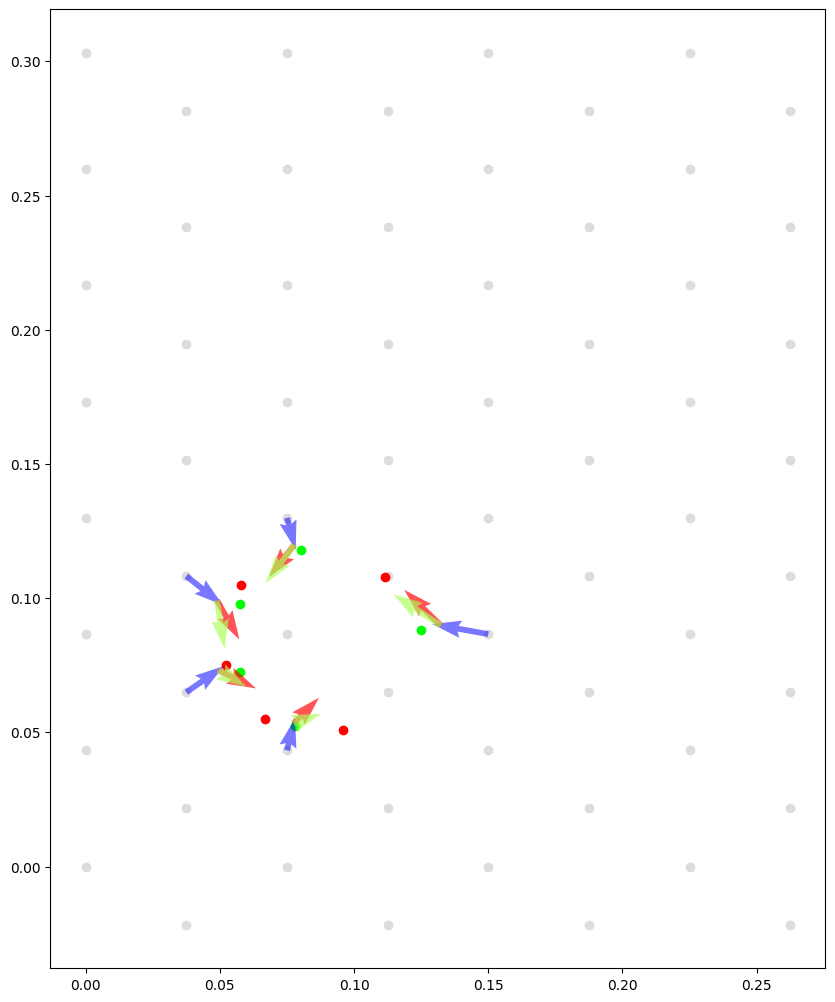

[[ 0.0258  0.0097]
 [-0.0282 -0.0275]
 [ 0.0095 -0.029 ]
 [-0.0229  0.0266]
 [ 0.0215 -0.0148]]
[[ 0.0305  0.0024]
 [-0.0364 -0.033 ]
 [ 0.005  -0.0495]
 [-0.0215  0.0248]
 [ 0.013  -0.0177]]
5


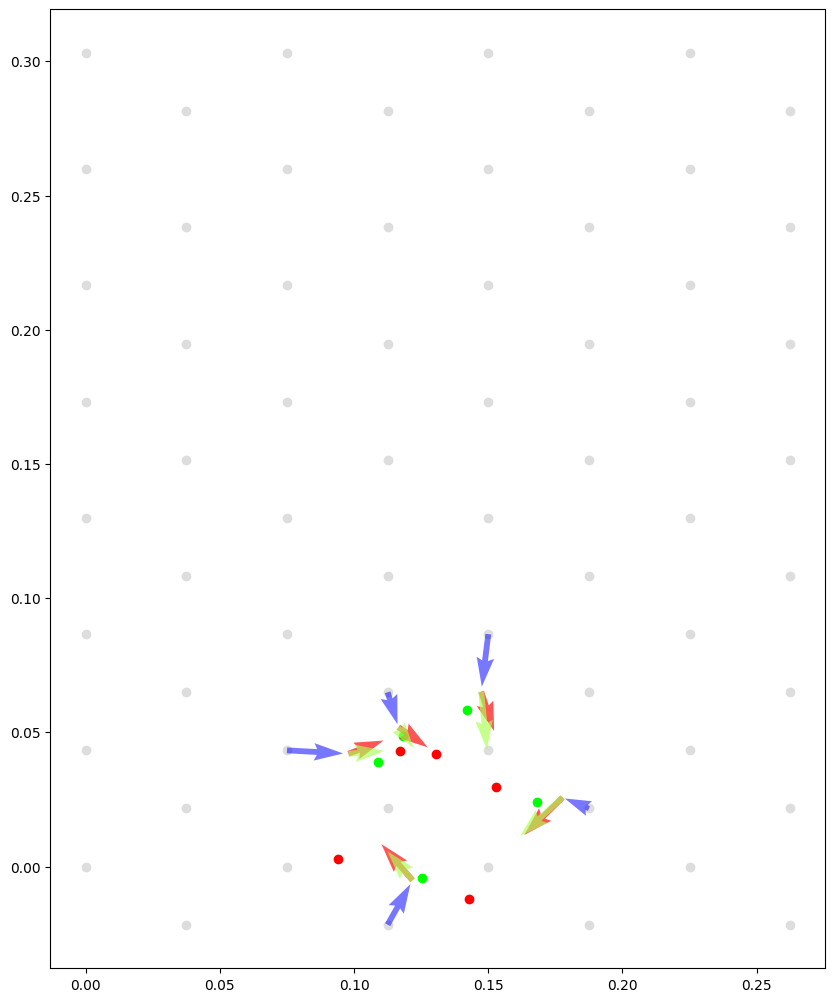

[[ 0.0291 -0.0257]
 [-0.0003  0.0208]
 [ 0.029  -0.0076]
 [ 0.0279  0.0231]
 [ 0.0092  0.0238]
 [ 0.0046 -0.0285]
 [ 0.0269 -0.0282]]
[[ 0.0459 -0.0289]
 [-0.0006  0.0141]
 [ 0.0407 -0.0053]
 [ 0.0384  0.0236]
 [ 0.0071  0.0206]
 [ 0.0038 -0.0389]
 [ 0.0271 -0.0359]]
7


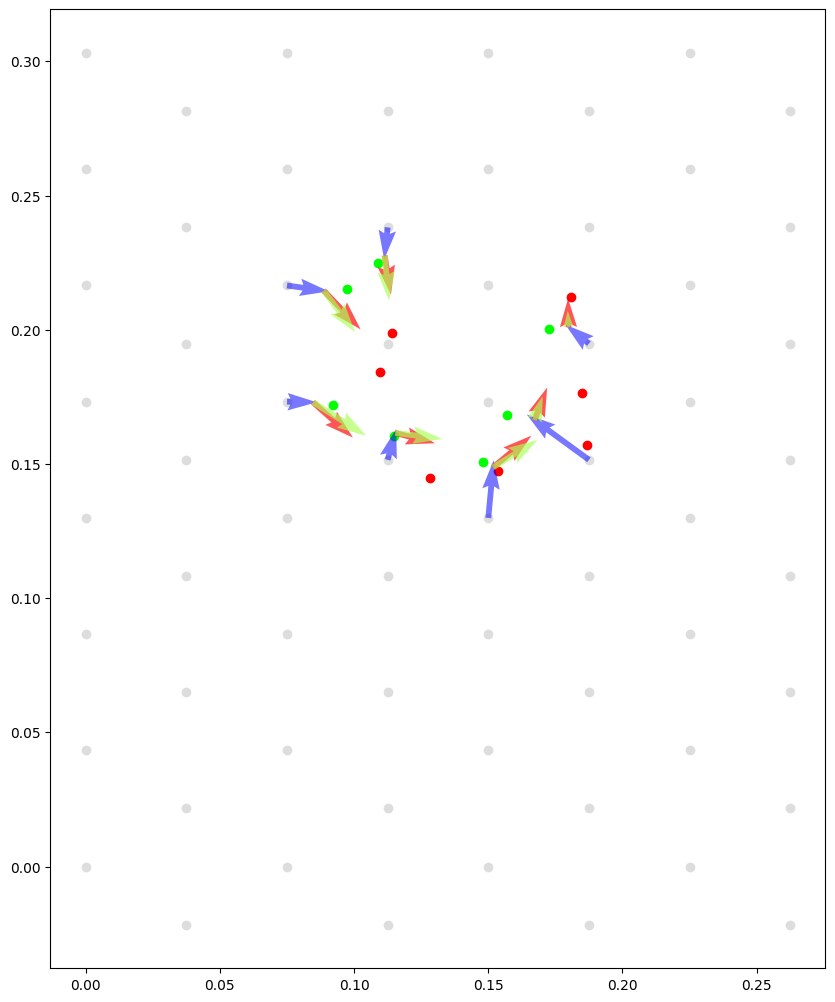

[[ 0.0135 -0.0298]
 [ 0.0219  0.0286]
 [-0.0266  0.0297]
 [ 0.0299 -0.0126]
 [ 0.0299 -0.0007]
 [-0.0289 -0.0067]
 [ 0.0295  0.0295]]
[[ 0.0147 -0.0609]
 [ 0.0286  0.0518]
 [-0.0318  0.0646]
 [ 0.0914 -0.0192]
 [ 0.0684  0.0025]
 [-0.0444 -0.0101]
 [ 0.0576  0.0649]]
7


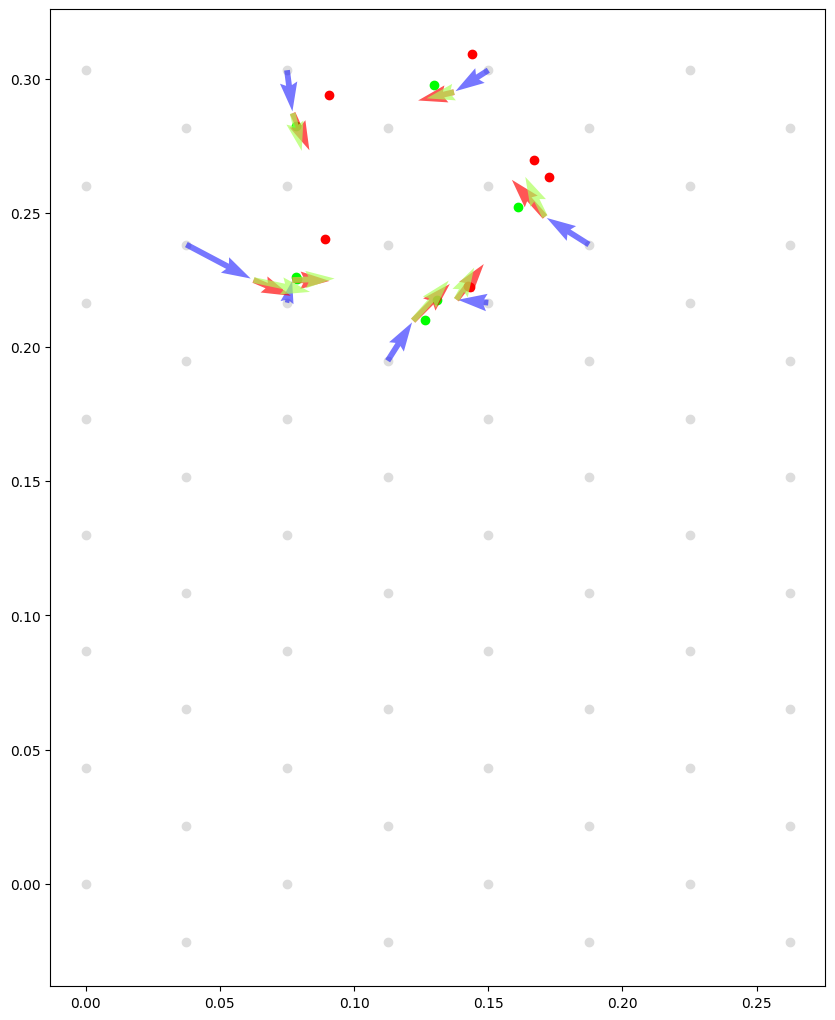

[[-0.0266 -0.0257]
 [ 0.0248 -0.0264]
 [-0.0118 -0.0141]
 [ 0.0255  0.007 ]
 [ 0.0284 -0.0052]
 [ 0.0206 -0.0076]]
[[-0.0261 -0.031 ]
 [ 0.026  -0.034 ]
 [-0.0043 -0.0161]
 [ 0.0295  0.0029]
 [ 0.0374 -0.0093]
 [ 0.02   -0.0062]]
6


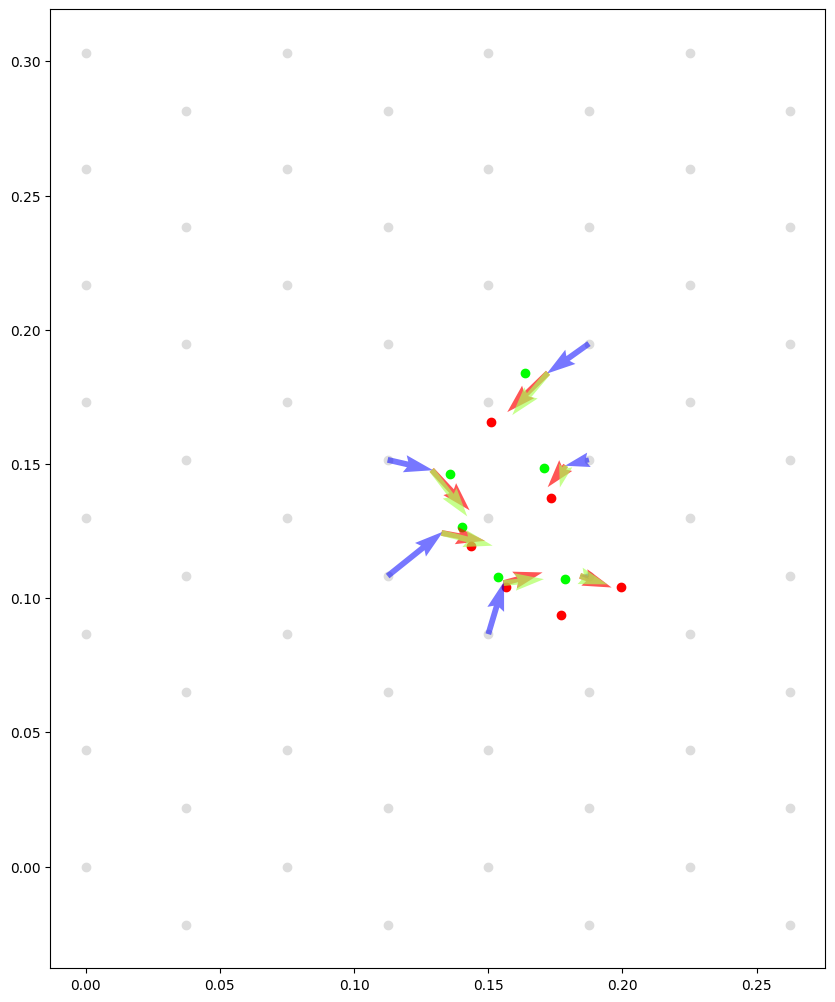

[[ 0.0117  0.0136]
 [ 0.004  -0.0273]
 [-0.0182 -0.0232]
 [ 0.0053 -0.0183]
 [ 0.0099  0.0256]]
[[ 0.0073  0.0093]
 [ 0.0004 -0.0373]
 [-0.0206 -0.0204]
 [ 0.0032 -0.0136]
 [ 0.0061  0.0289]]
5


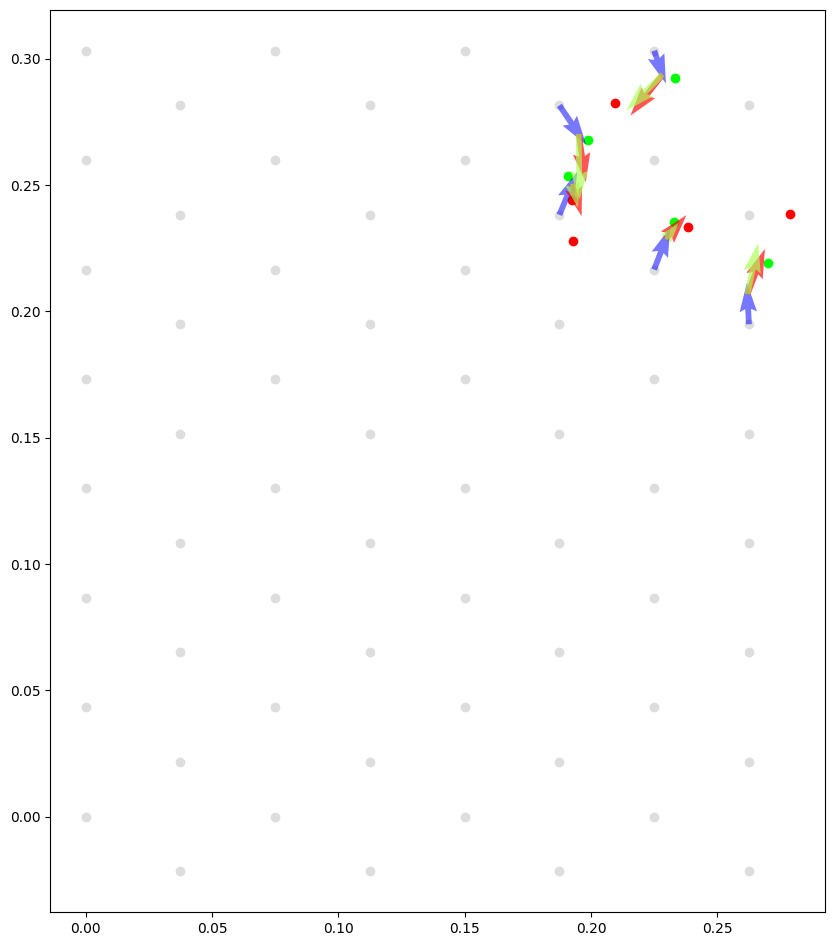

[[-0.0287 -0.0254]
 [ 0.0292 -0.0141]
 [ 0.0144 -0.0295]
 [-0.0136  0.0056]
 [-0.0281 -0.0296]
 [ 0.0281  0.0114]]
[[-0.0457 -0.0288]
 [ 0.0414 -0.0121]
 [ 0.0071 -0.0526]
 [-0.0129  0.0062]
 [-0.0408 -0.0518]
 [ 0.0333  0.01  ]]
6


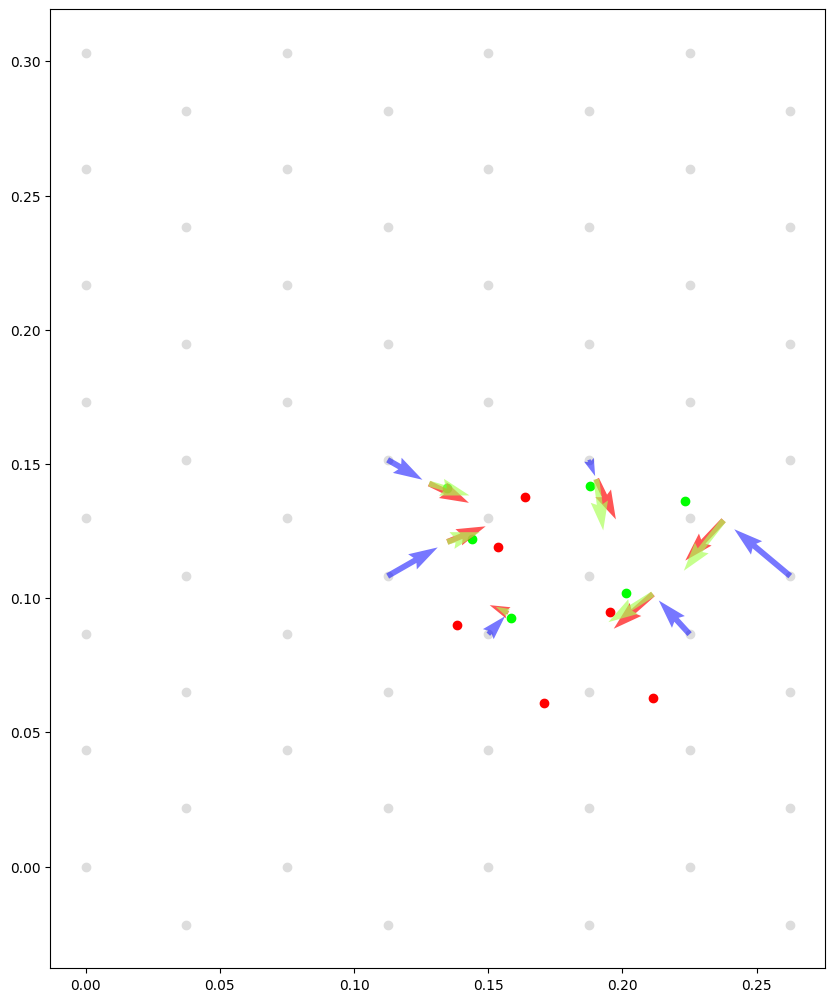

[[-0.0298 -0.0247]
 [ 0.0275  0.0296]
 [-0.0002 -0.029 ]
 [ 0.0003  0.0299]
 [ 0.0296 -0.0087]
 [ 0.0294 -0.0245]
 [-0.0176  0.0297]
 [-0.0274  0.013 ]]
[[-0.0527 -0.0206]
 [ 0.0312  0.0547]
 [ 0.004  -0.0439]
 [ 0.0047  0.0693]
 [ 0.065  -0.006 ]
 [ 0.056  -0.0337]
 [-0.0128  0.0477]
 [-0.031   0.0031]]
8


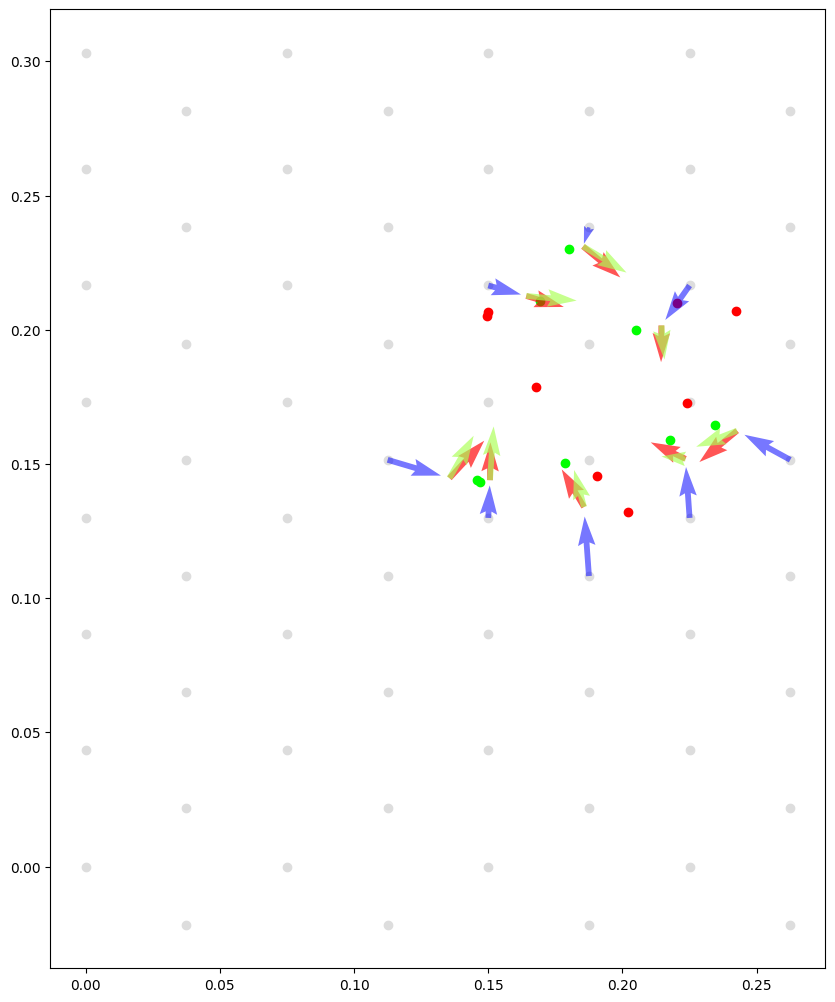

[[-0.0298 -0.0024]
 [-0.0254  0.0292]
 [ 0.0151 -0.0275]
 [ 0.0025  0.0299]
 [ 0.0293  0.0275]
 [ 0.027   0.0298]
 [ 0.0292  0.016 ]
 [-0.0295 -0.0253]]
[[-5.6204e-02 -7.6941e-05]
 [-2.4220e-02  4.4977e-02]
 [ 1.5509e-02 -3.6959e-02]
 [-1.7740e-03  8.0844e-02]
 [ 5.0556e-02  3.4204e-02]
 [ 3.6305e-02  7.0968e-02]
 [ 4.8453e-02  6.5733e-03]
 [-5.4892e-02 -2.6639e-02]]
8


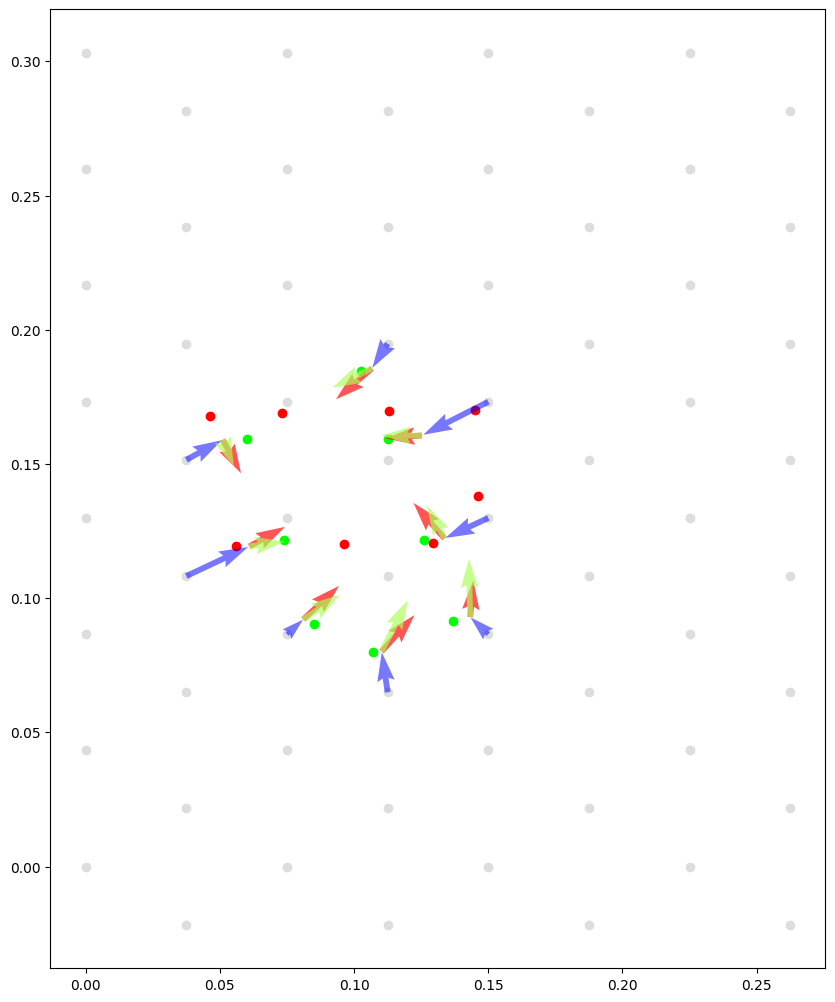

[[-0.0155 -0.0246]
 [ 0.0061  0.0241]
 [ 0.0271 -0.0167]
 [ 0.0277 -0.0279]]
[[-0.0115 -0.0235]
 [ 0.0064  0.0205]
 [ 0.0361 -0.0178]
 [ 0.0274 -0.0354]]
4


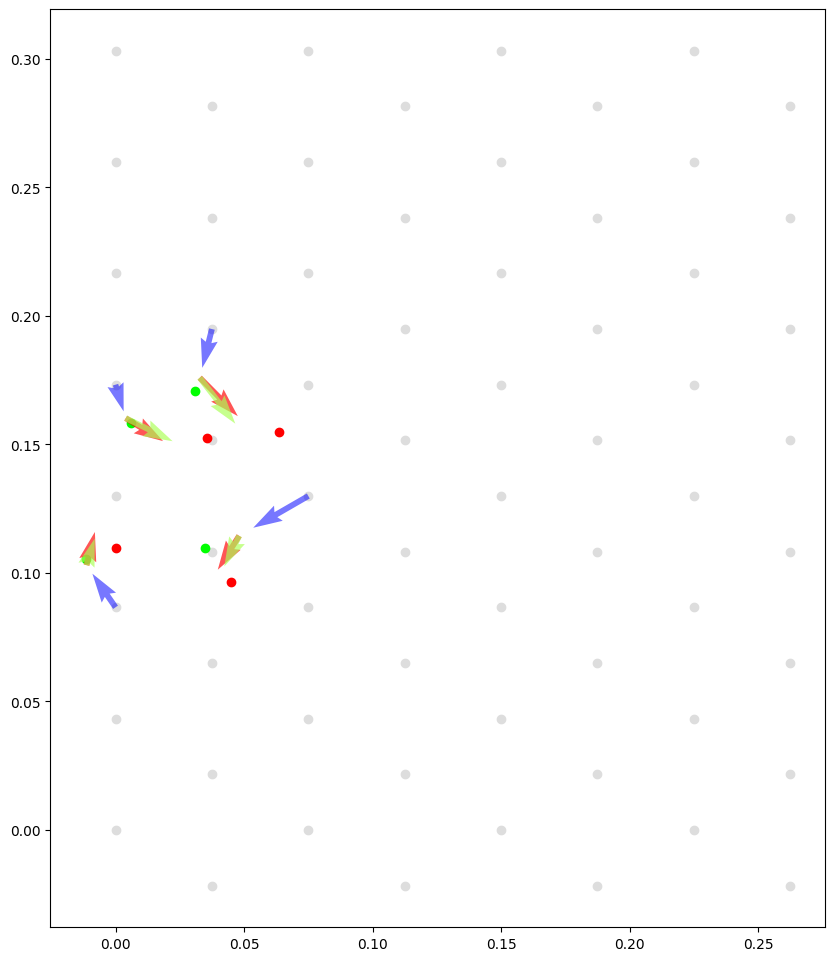

[[ 0.0209 -0.0272]
 [-0.0149 -0.0235]
 [ 0.019   0.0046]
 [ 0.0192 -0.0168]
 [ 0.0207  0.0211]
 [-0.0035  0.0231]]
[[ 0.0158 -0.0265]
 [-0.0176 -0.0208]
 [ 0.0146 -0.0007]
 [ 0.0124 -0.0136]
 [ 0.0152  0.0178]
 [-0.0057  0.0158]]
6


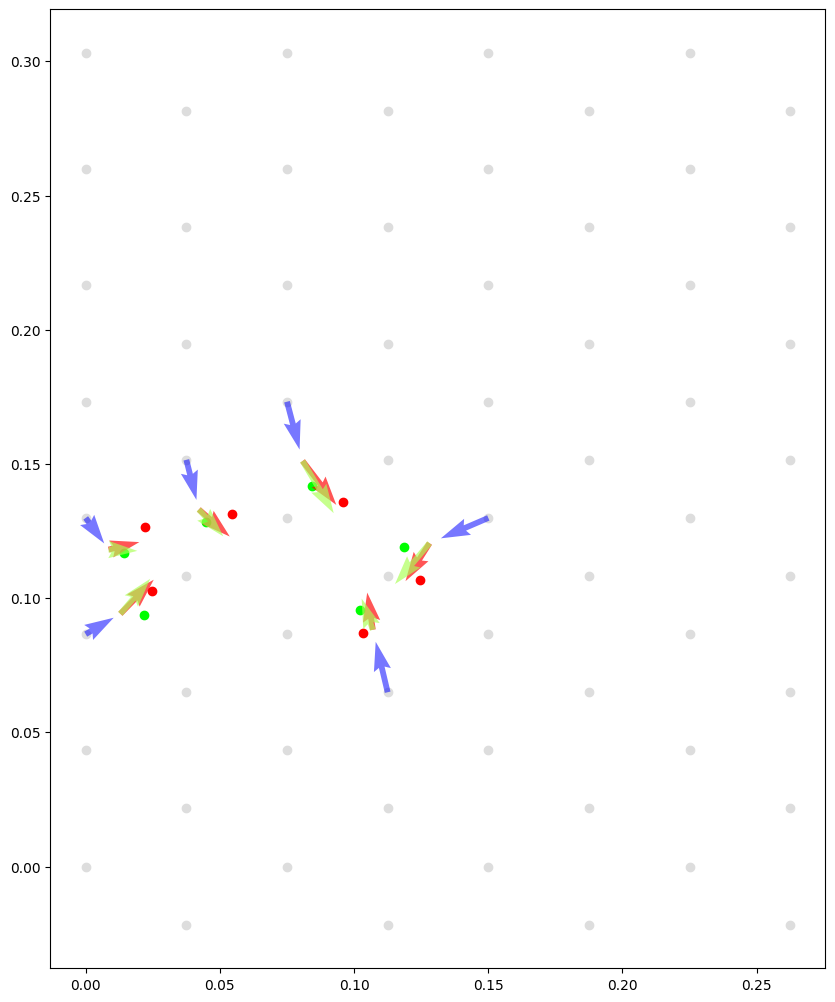

[[ 0.0298 -0.0265]
 [-0.0289 -0.0135]
 [ 0.0178  0.029 ]
 [-0.0263  0.0244]
 [-0.0081 -0.0297]
 [-0.0287 -0.0283]]
[[ 0.0788 -0.035 ]
 [-0.0519 -0.007 ]
 [ 0.0119  0.0383]
 [-0.034   0.0199]
 [-0.0093 -0.0621]
 [-0.0508 -0.038 ]]
6


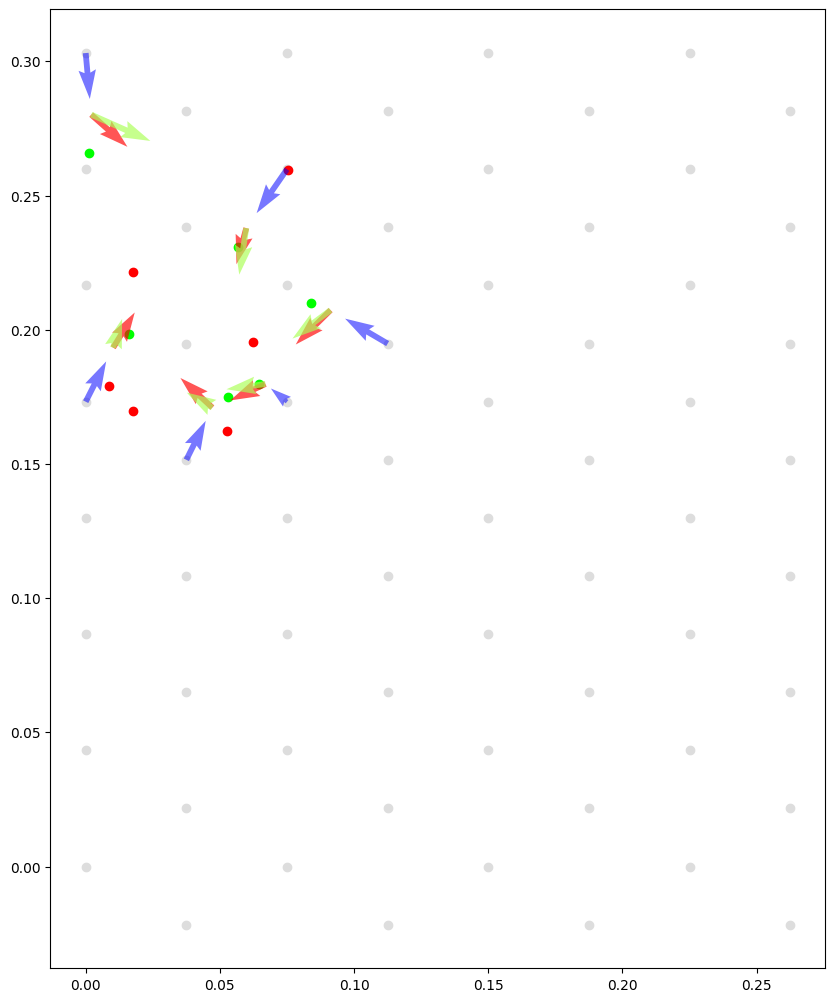

[[-0.0252  0.0278]
 [-0.002   0.0198]
 [-0.0257  0.0007]
 [-0.027  -0.0279]
 [ 0.0274 -0.0292]
 [-0.0266 -0.0209]
 [-0.001  -0.0276]]
[[-0.0228  0.0341]
 [-0.0023  0.0182]
 [-0.0248  0.0006]
 [-0.0322 -0.0331]
 [ 0.0268 -0.0504]
 [-0.0309 -0.0158]
 [-0.0002 -0.0398]]
7


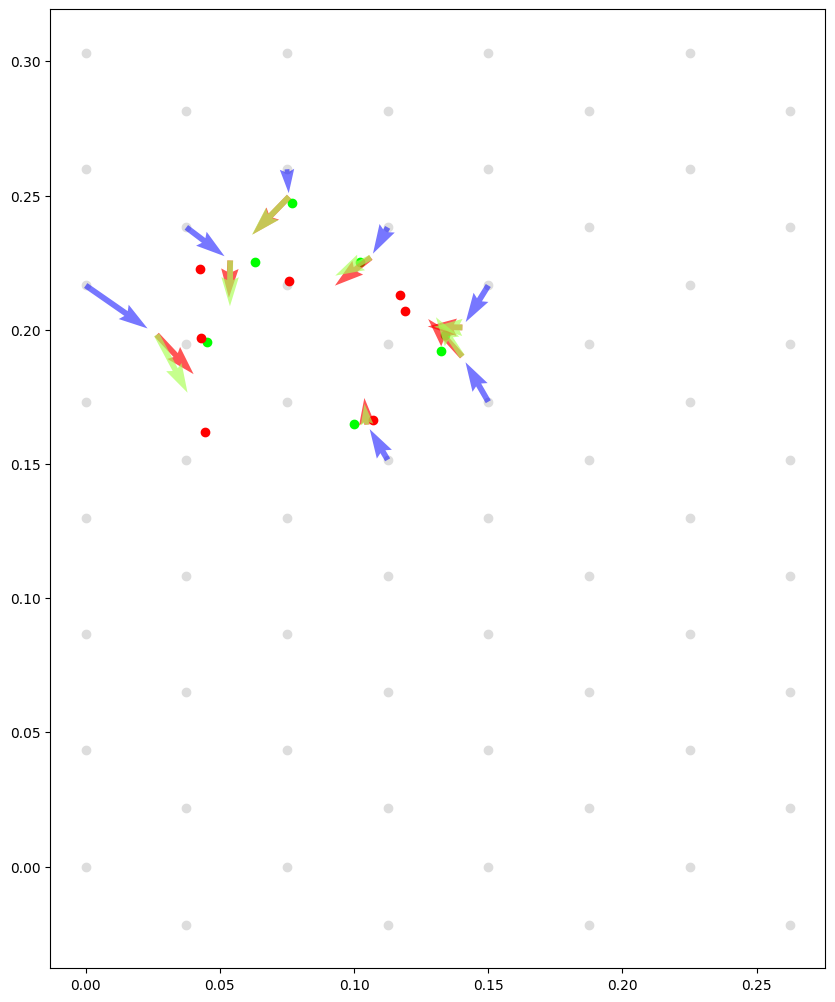

[[ 0.0233  0.0241]
 [-0.0018  0.0266]
 [-0.0278 -0.0065]
 [ 0.0295  0.0068]]
[[ 0.024   0.021 ]
 [-0.0023  0.02  ]
 [-0.0238 -0.0074]
 [ 0.0488  0.0073]]
4


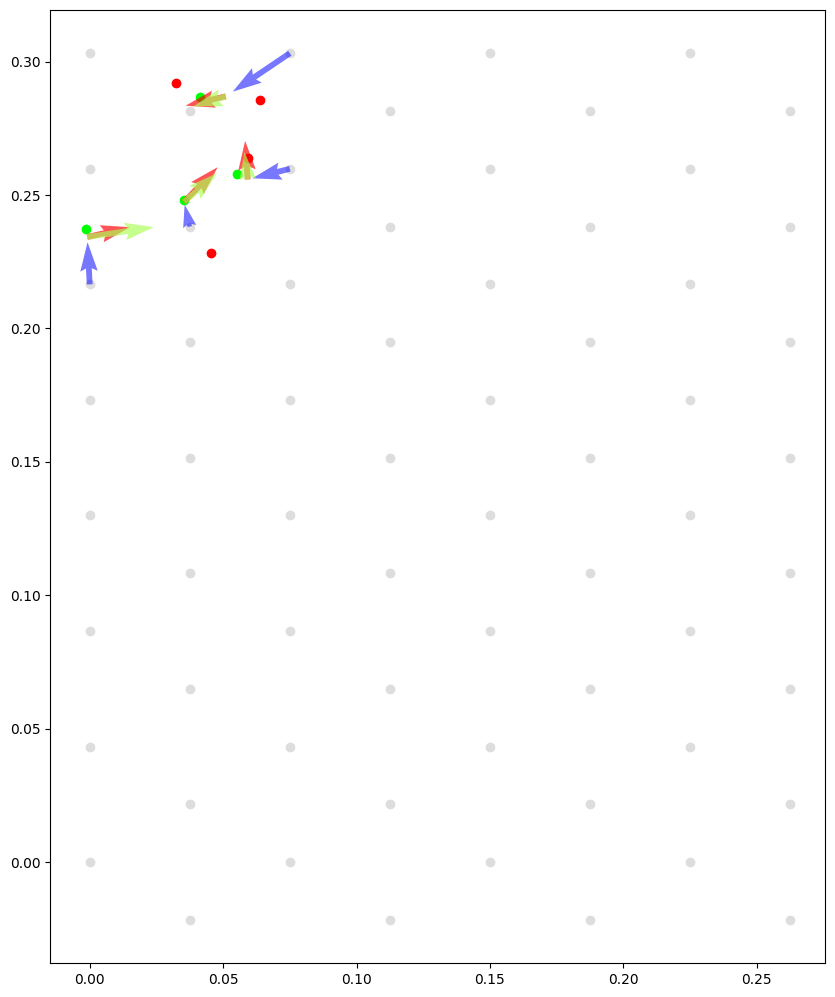

[[ 0.0122  0.0288]
 [-0.0201  0.0274]
 [-0.0178  0.0086]
 [-0.0261  0.0251]
 [ 0.0168 -0.0005]
 [ 0.0003  0.0276]
 [-0.0276 -0.0105]]
[[ 0.0072  0.0397]
 [-0.019   0.0348]
 [-0.0075  0.0048]
 [-0.0294  0.0244]
 [ 0.0129  0.0032]
 [ 0.0011  0.0345]
 [-0.0267 -0.0073]]
7


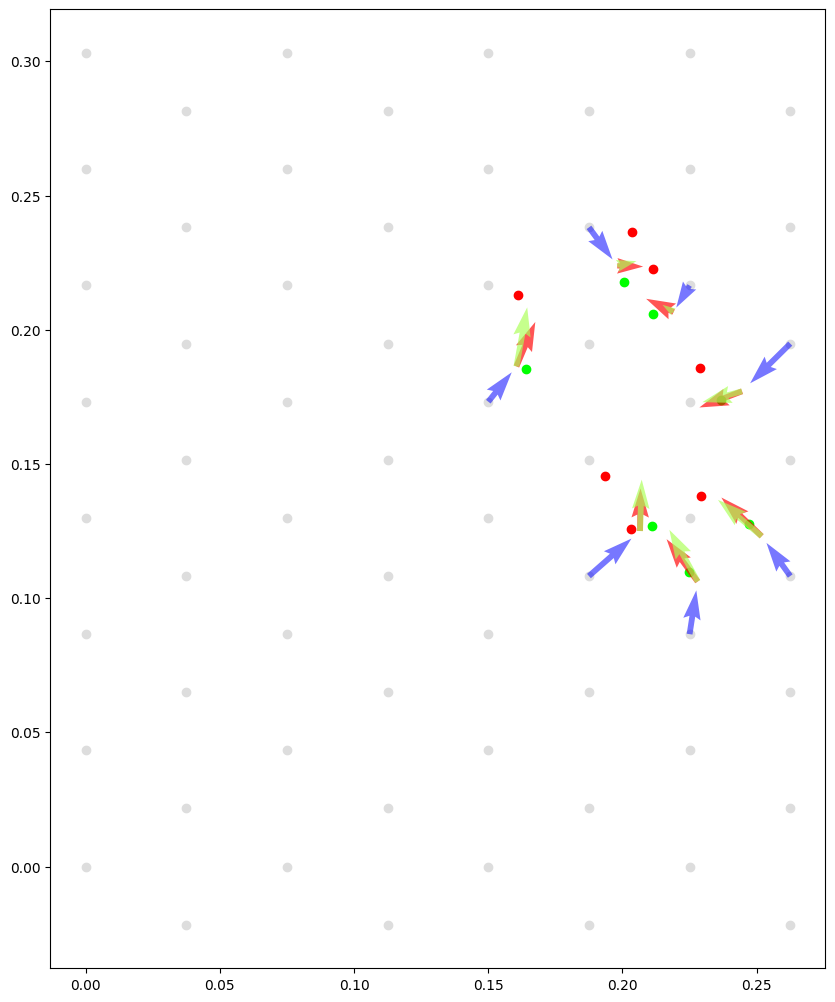

[[-0.0291  0.0029]
 [ 0.0109  0.0295]
 [ 0.0285 -0.0299]
 [ 0.0237 -0.0299]
 [-0.0247  0.0298]
 [-0.0176 -0.0275]
 [ 0.0297 -0.0286]
 [ 0.029   0.0095]]
[[-4.2832e-02 -6.6942e-05]
 [ 6.3182e-03  4.6088e-02]
 [ 5.5377e-02 -7.9386e-02]
 [ 2.0014e-02 -6.6258e-02]
 [-3.3365e-02  7.8814e-02]
 [-2.0303e-02 -3.4239e-02]
 [ 6.1659e-02 -4.3915e-02]
 [ 3.4857e-02  1.2639e-02]]
8


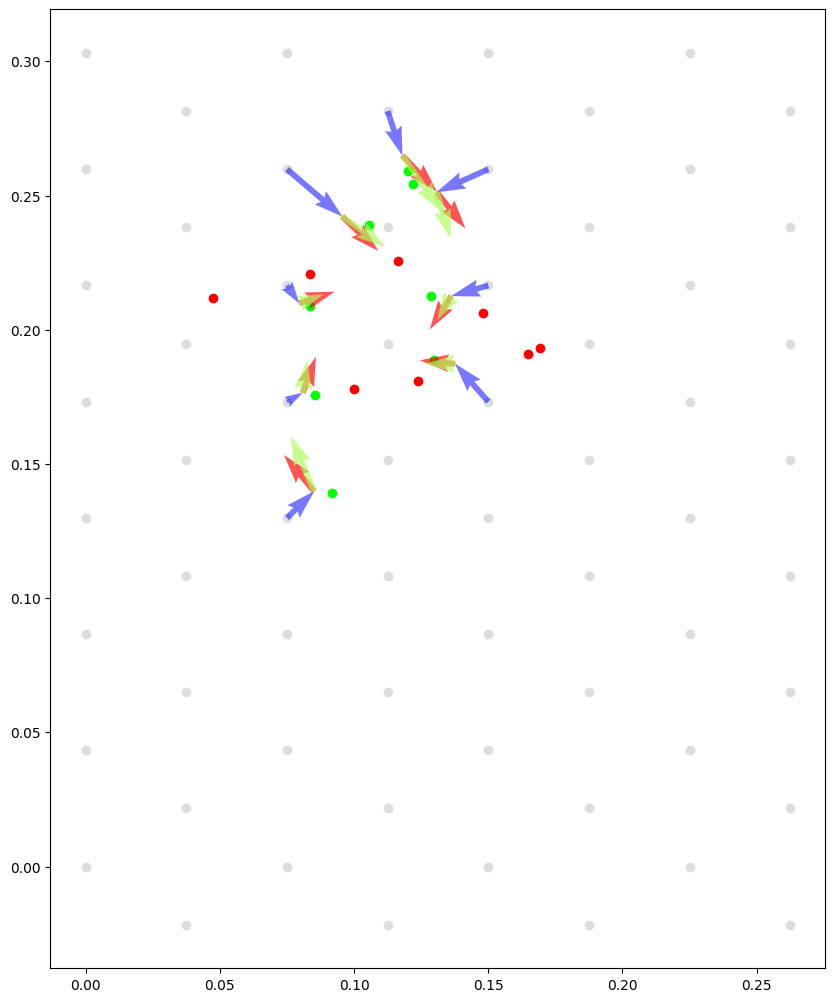

[[ 0.0296 -0.0045]
 [ 0.0161  0.0299]
 [-0.0229 -0.0289]
 [-0.0297  0.0121]
 [ 0.0141  0.0295]]
[[ 0.0493 -0.0036]
 [ 0.0093  0.0892]
 [-0.0116 -0.0379]
 [-0.0656  0.0115]
 [ 0.0128  0.0536]]
5


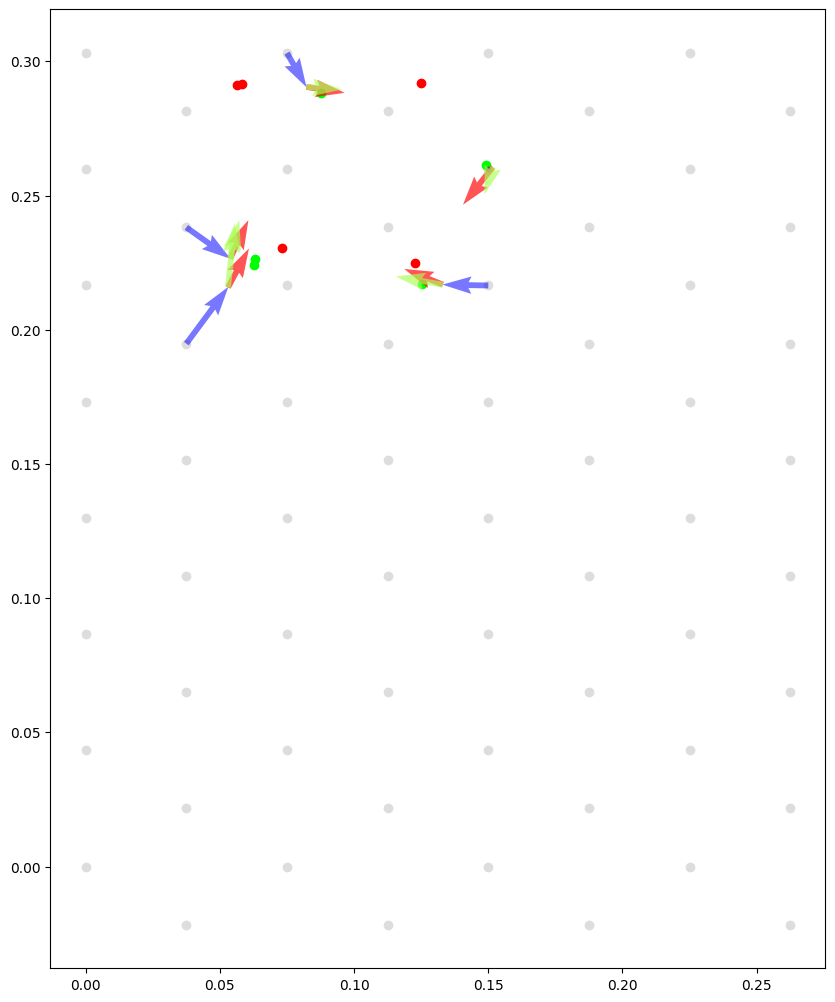

[[-0.0117 -0.0162]
 [ 0.027   0.0269]
 [ 0.0233  0.0289]
 [-0.0269  0.0279]
 [-0.0216  0.0294]
 [ 0.0161 -0.0176]]
[[-0.0039 -0.0105]
 [ 0.0286  0.0345]
 [ 0.0201  0.0441]
 [-0.0331  0.0335]
 [-0.0222  0.0484]
 [ 0.0095 -0.0115]]
6


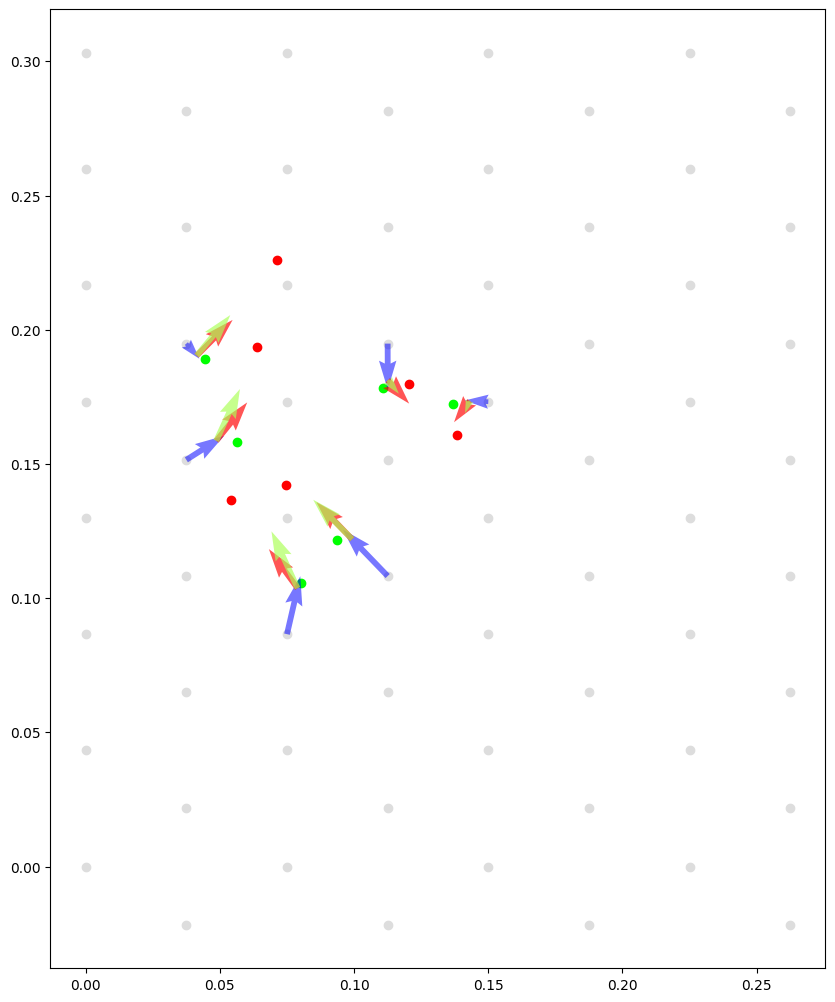

[[ 0.0295  0.0143]
 [ 0.0128 -0.0299]
 [-0.0202 -0.0298]
 [ 0.0258  0.0266]
 [ 0.0249 -0.0299]
 [ 0.0181  0.0297]
 [-0.025  -0.0281]]
[[ 0.0469  0.0113]
 [ 0.0167 -0.0822]
 [-0.0176 -0.0673]
 [ 0.0291  0.0306]
 [ 0.0271 -0.0739]
 [ 0.0112  0.0541]
 [-0.0225 -0.0367]]
7


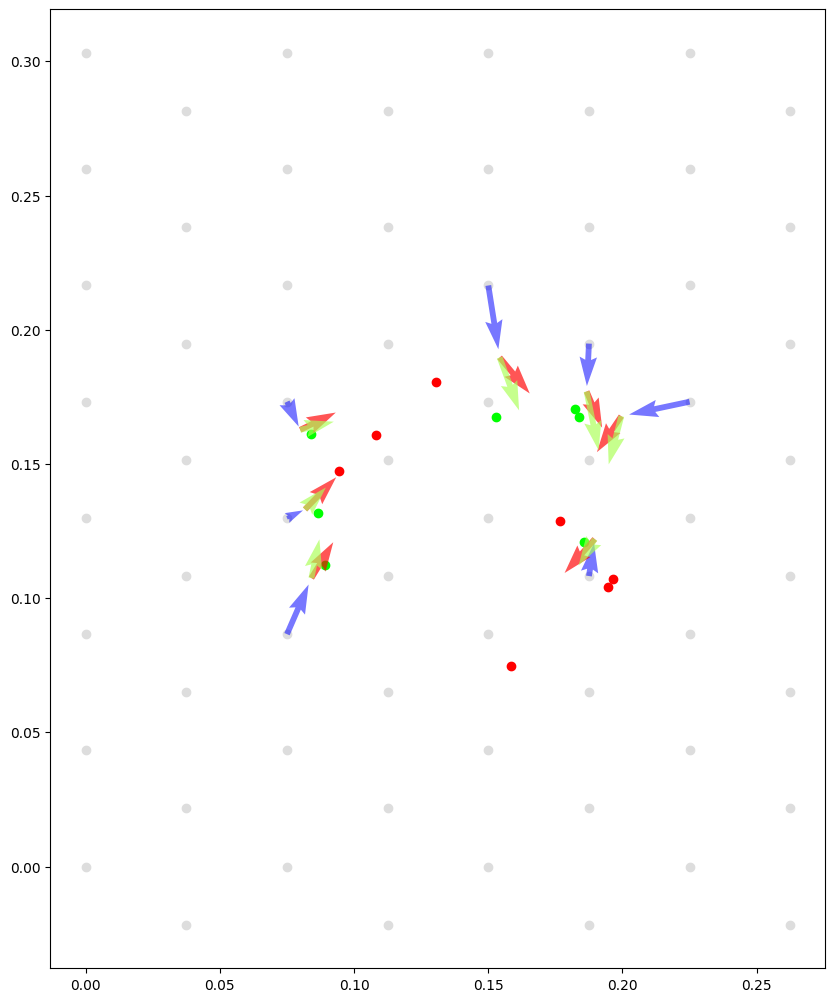

[[ 0.0299 -0.0266]
 [-0.0155  0.0299]
 [ 0.0248 -0.0299]
 [-0.0299  0.0229]
 [ 0.0296  0.0048]
 [ 0.018   0.0291]
 [-0.0046 -0.0298]
 [-0.0274 -0.0172]]
[[ 0.0759 -0.0404]
 [-0.0148  0.0728]
 [ 0.0196 -0.0852]
 [-0.071   0.0272]
 [ 0.0469  0.0016]
 [ 0.0096  0.0374]
 [-0.005  -0.0677]
 [-0.0373 -0.011 ]]
8


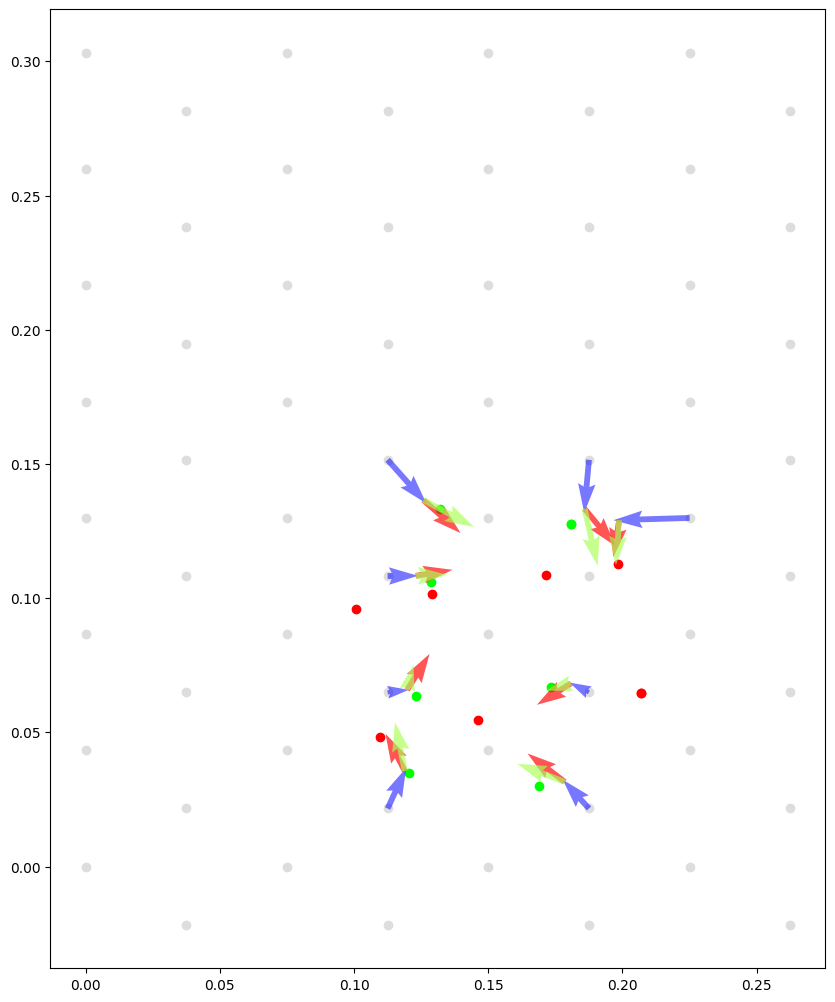

[[-0.0155 -0.0144]
 [-0.0063  0.0285]
 [ 0.0267  0.0051]]
[[-0.0211 -0.0143]
 [-0.0061  0.0366]
 [ 0.03   -0.0009]]
3


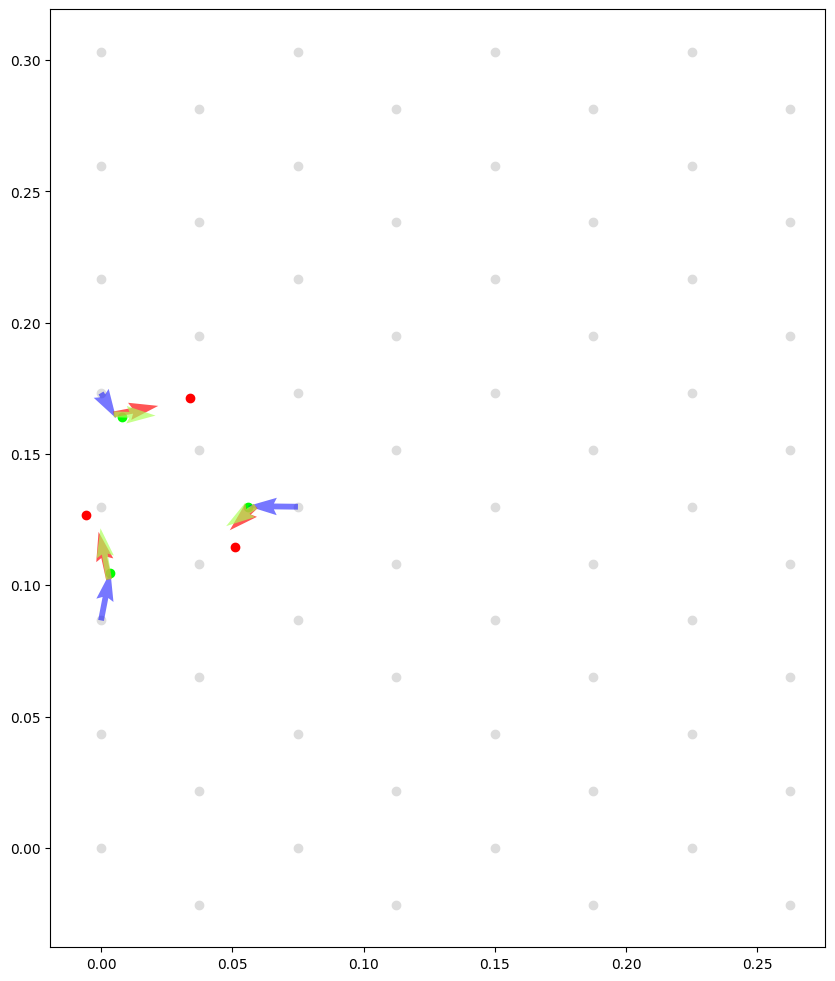

[[-0.0295  0.0255]
 [ 0.0288 -0.0252]
 [-0.0288  0.0294]
 [-0.0288 -0.0295]
 [-0.029  -0.0175]
 [ 0.0282  0.0298]
 [ 0.0148 -0.0199]]
[[-0.0488  0.027 ]
 [ 0.0449 -0.0307]
 [-0.037   0.0471]
 [-0.0419 -0.0509]
 [-0.0416 -0.0175]
 [ 0.0419  0.064 ]
 [ 0.009  -0.0186]]
7


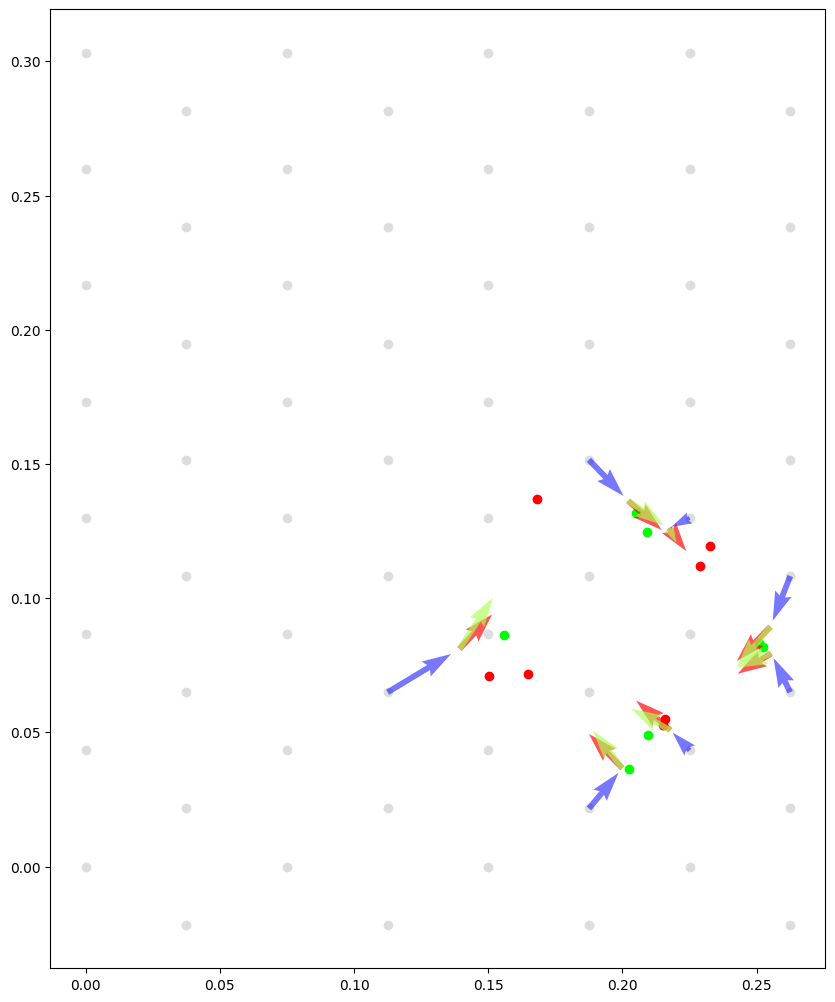

[[-0.0177  0.0291]
 [ 0.0267  0.0228]
 [-0.012  -0.0298]
 [-0.0283 -0.0292]
 [-0.029  -0.0139]
 [-0.0297 -0.0252]
 [ 0.0255  0.0287]
 [ 0.0263 -0.0266]]
[[-0.0089  0.0421]
 [ 0.0312  0.0209]
 [-0.0078 -0.0594]
 [-0.0393 -0.055 ]
 [-0.0406 -0.0087]
 [-0.0417 -0.0311]
 [ 0.0243  0.0423]
 [ 0.021  -0.0318]]
8


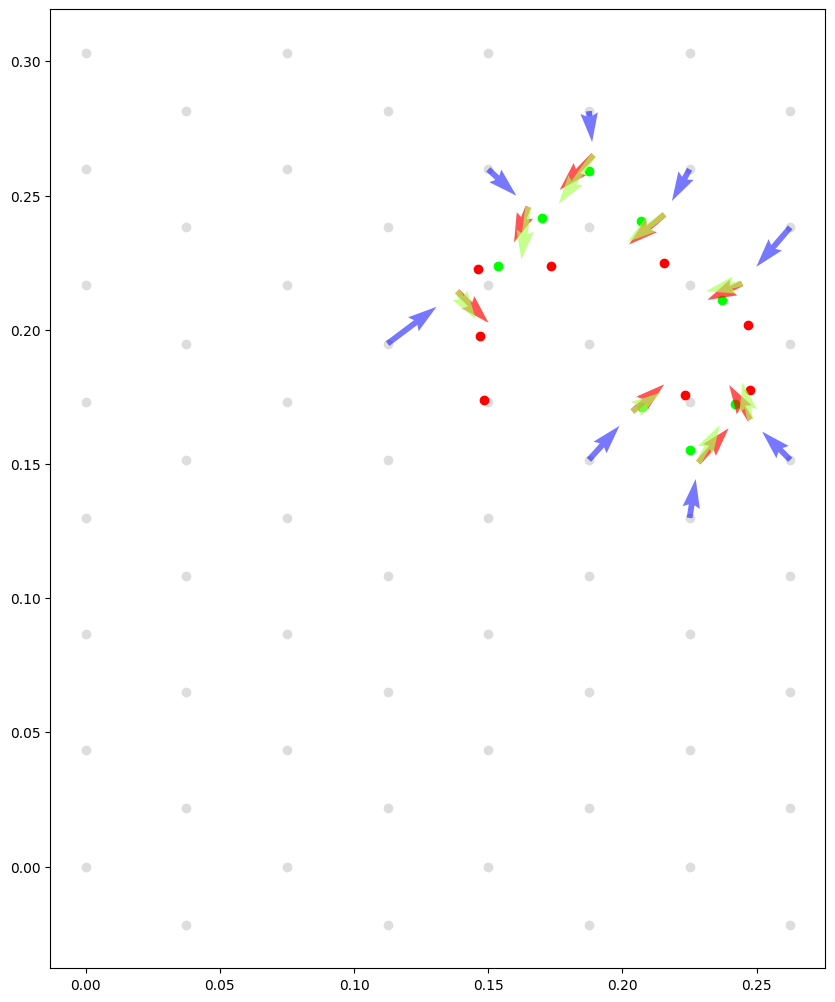

[[-0.0245 -0.0154]
 [ 0.0289  0.0282]
 [-0.0296  0.0177]
 [ 0.0282  0.0299]
 [ 0.0081  0.0296]
 [ 0.0202 -0.0266]
 [ 0.0287 -0.0285]
 [ 0.0292  0.0004]]
[[-0.0197 -0.0106]
 [ 0.0448  0.0413]
 [-0.0529  0.0106]
 [ 0.0438  0.0769]
 [ 0.0073  0.0585]
 [ 0.0197 -0.0322]
 [ 0.0411 -0.0415]
 [ 0.0409  0.0053]]
8


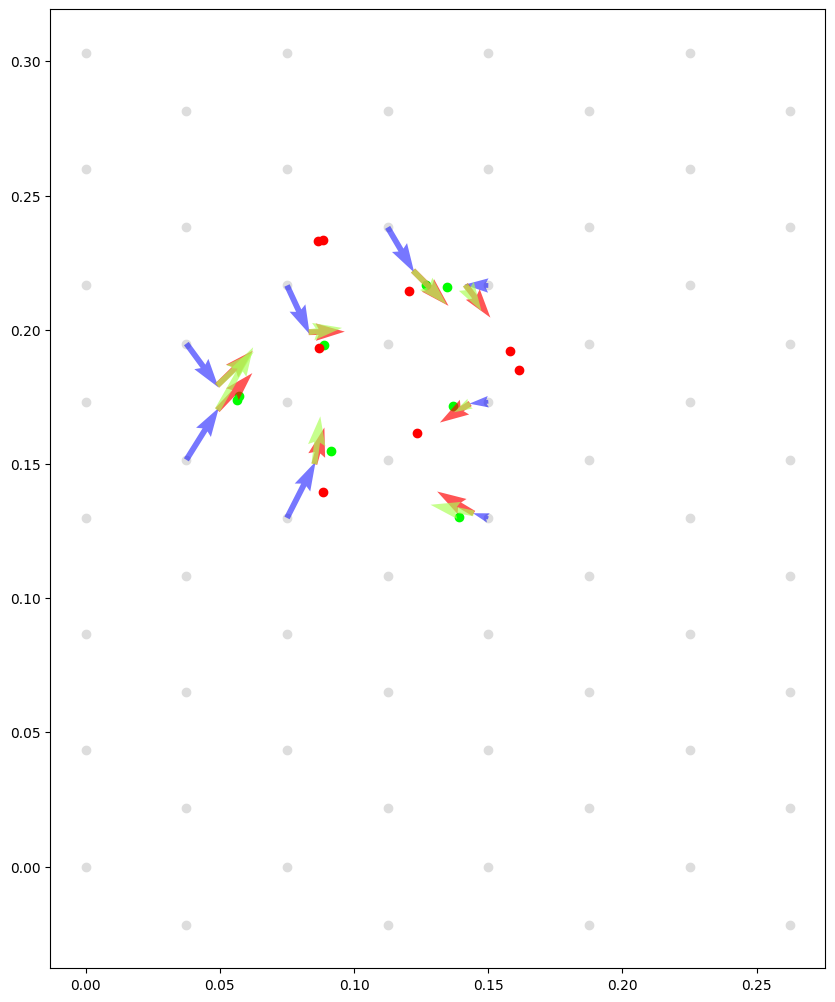

[[-0.0244  0.0284]
 [ 0.0282  0.0173]
 [-0.0273  0.0206]
 [-0.0067  0.0253]
 [-0.0073 -0.0293]]
[[-0.0264  0.0414]
 [ 0.0356  0.0164]
 [-0.0375  0.0107]
 [-0.0019  0.03  ]
 [-0.0019 -0.0405]]
5


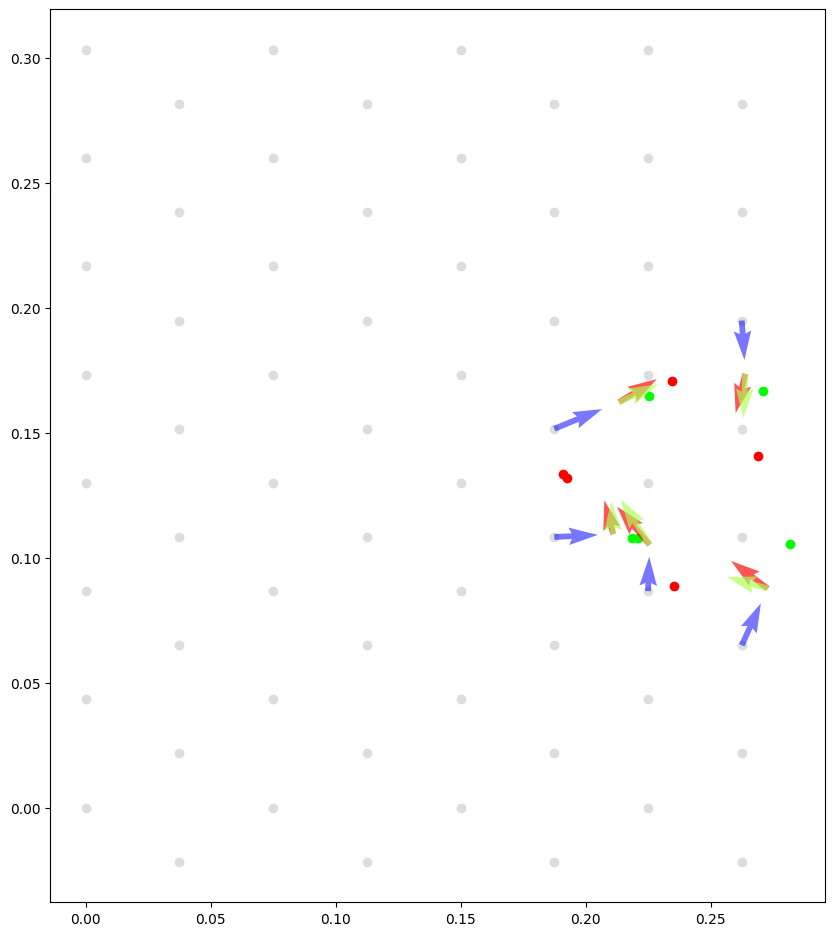

[[-0.0295  0.0167]
 [-0.0207 -0.0298]
 [ 0.0212  0.0181]
 [ 0.0234 -0.0299]
 [ 0.027  -0.0275]
 [-0.0297 -0.021 ]]
[[-0.0605  0.0187]
 [-0.0248 -0.0654]
 [ 0.0076  0.0152]
 [ 0.015  -0.0909]
 [ 0.0268 -0.0382]
 [-0.0595 -0.015 ]]
6


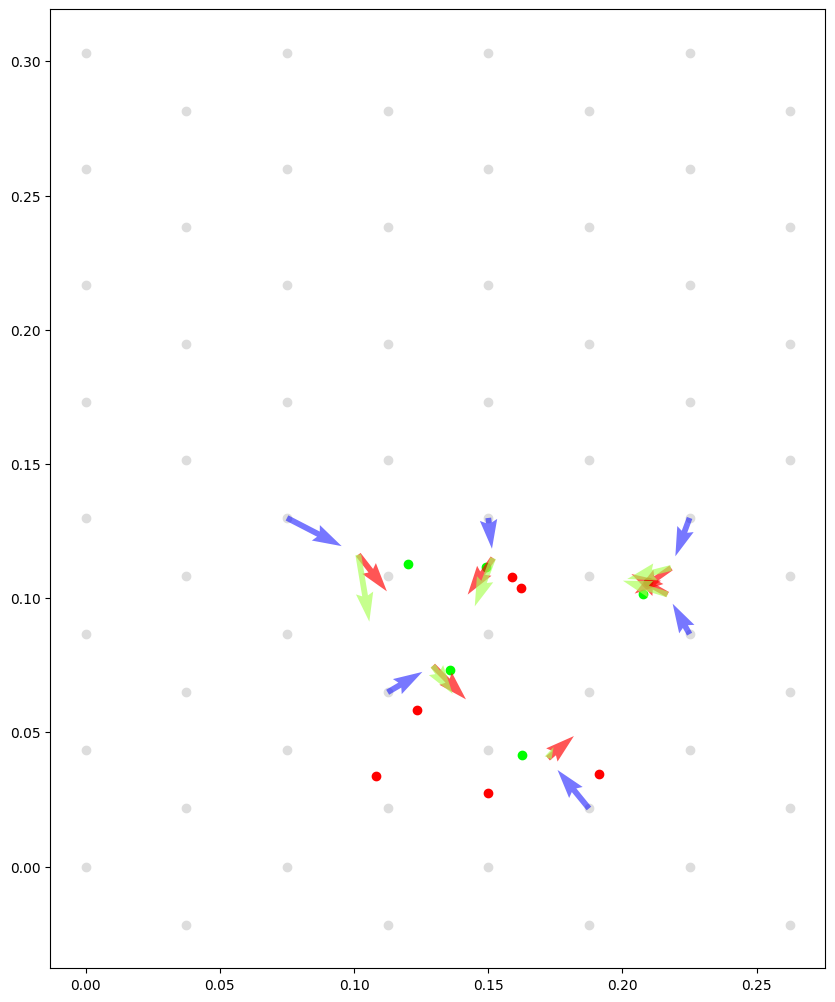

[[ 0.0125 -0.0299]
 [-0.0297 -0.0167]
 [ 0.0253 -0.0296]
 [ 0.0285 -0.026 ]
 [-0.0269  0.0273]
 [-0.0197  0.0298]]
[[ 0.0048 -0.0697]
 [-0.0757 -0.0117]
 [ 0.028  -0.0628]
 [ 0.0345 -0.0333]
 [-0.0394  0.0308]
 [-0.0233  0.071 ]]
6


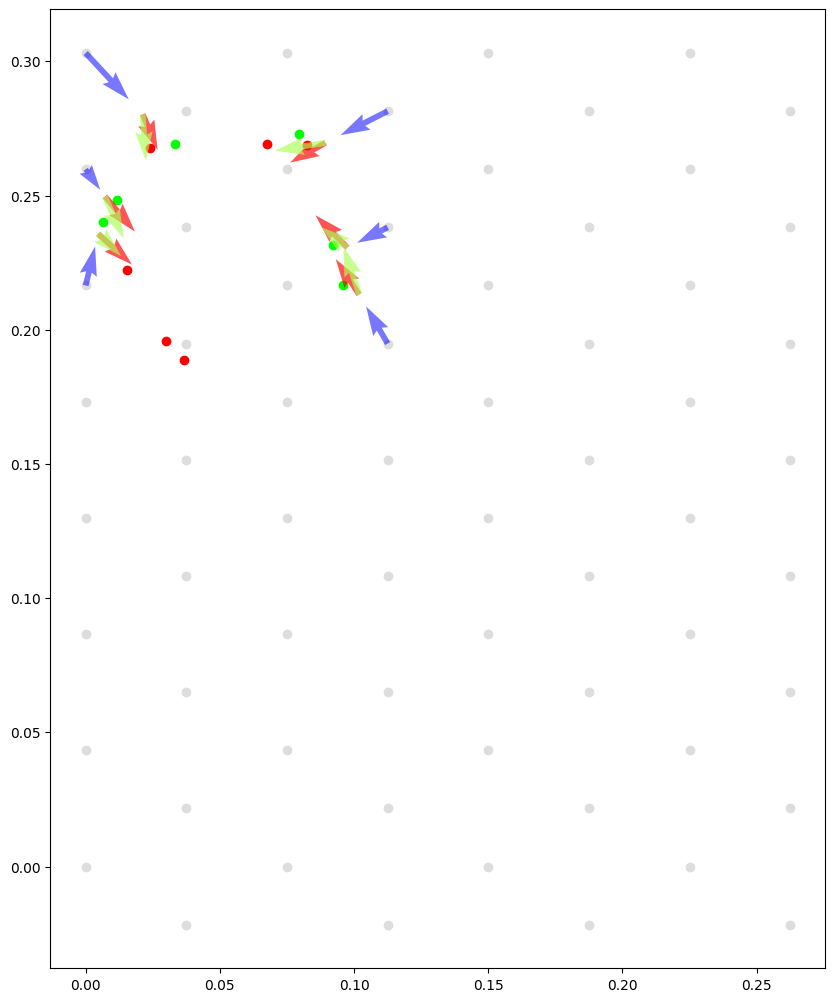

[[ 0.0266  0.0143]
 [-0.0288  0.0027]
 [ 0.0174 -0.0292]
 [-0.021  -0.0168]
 [-0.0166  0.0153]]
[[ 0.0292  0.0134]
 [-0.0427  0.0077]
 [ 0.0121 -0.0347]
 [-0.0216 -0.0082]
 [-0.0099  0.0148]]
5


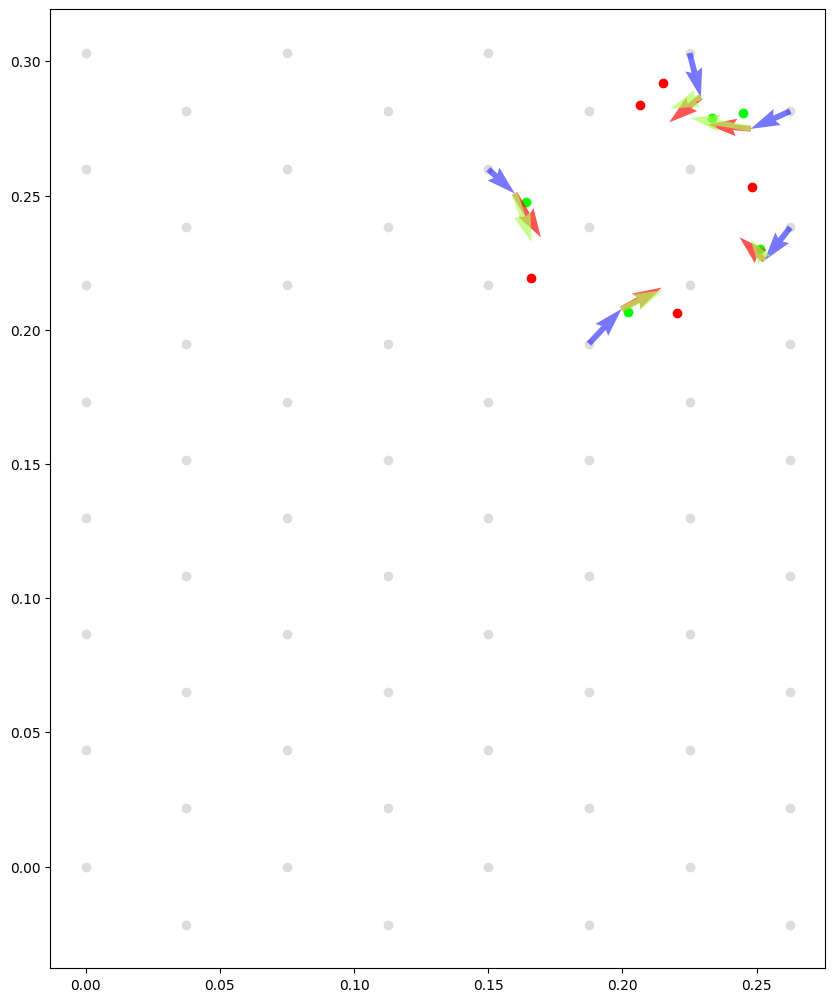

[[ 0.0127  0.002 ]
 [ 0.012   0.014 ]
 [ 0.029   0.0265]
 [ 0.0212  0.0234]
 [ 0.0122 -0.0049]
 [ 0.0128  0.0276]
 [ 0.0282 -0.016 ]
 [ 0.0283 -0.0088]]
[[ 0.013  -0.0018]
 [ 0.0124  0.0101]
 [ 0.0441  0.0277]
 [ 0.0196  0.0198]
 [ 0.0111 -0.006 ]
 [ 0.0101  0.0294]
 [ 0.0373 -0.0134]
 [ 0.0325 -0.0047]]
8


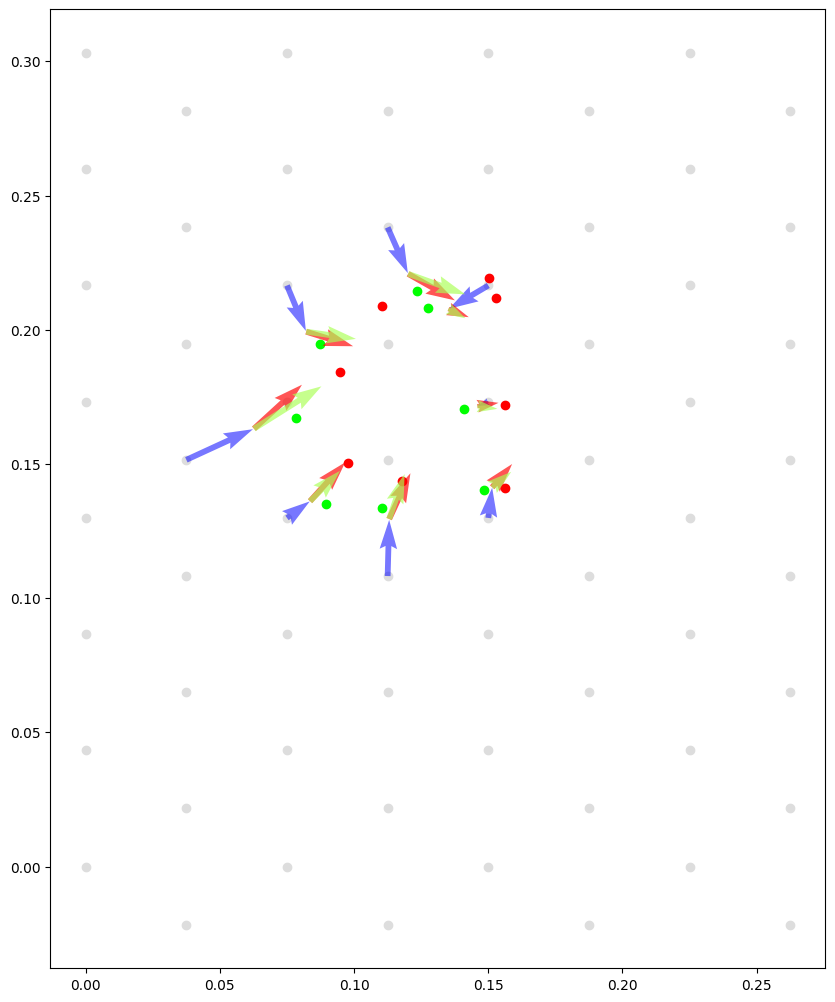

[[-0.0298  0.0215]
 [-0.0126  0.0299]
 [ 0.0297  0.0272]
 [-0.0163 -0.0298]
 [ 0.0275  0.0121]
 [-0.0266 -0.0188]]
[[-0.0602  0.0315]
 [-0.006   0.0744]
 [ 0.0701  0.0462]
 [-0.0175 -0.0562]
 [ 0.0403  0.0097]
 [-0.0262 -0.0235]]
6


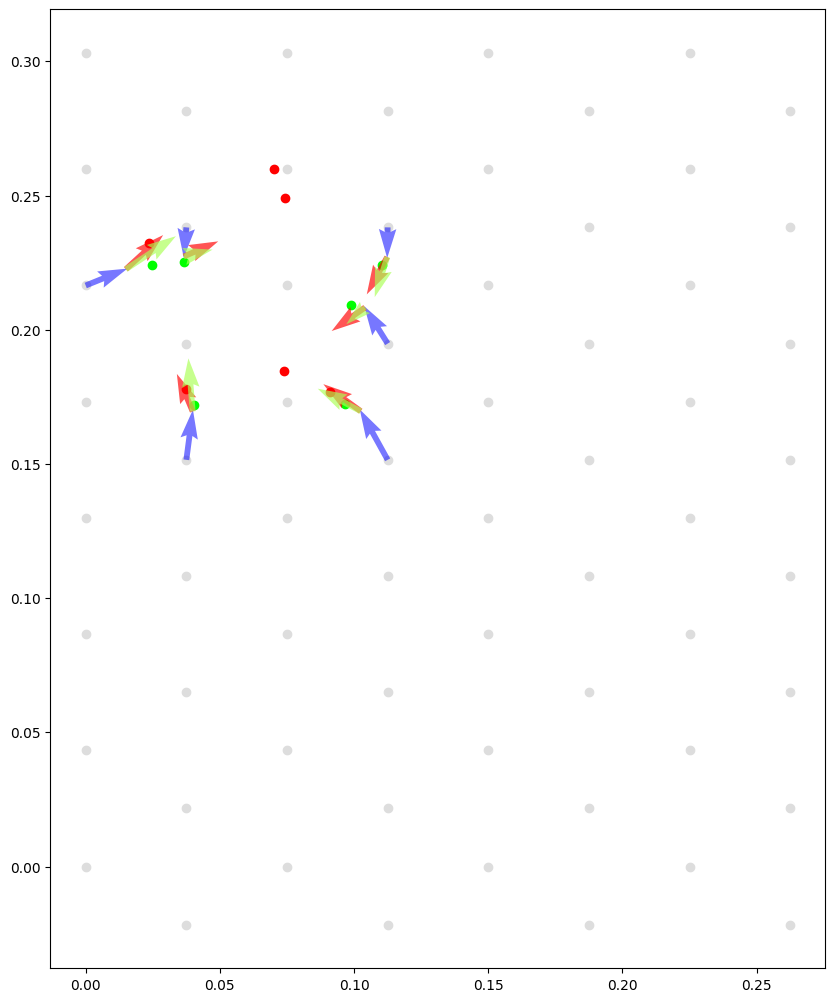

[[-0.0297 -0.0274]
 [ 0.0294 -0.0255]
 [-0.0292  0.0054]
 [-0.0163 -0.0298]
 [ 0.0298  0.0139]
 [ 0.0226  0.0287]]
[[-0.0654 -0.034 ]
 [ 0.0517 -0.0373]
 [-0.0505  0.0042]
 [-0.0171 -0.0712]
 [ 0.0698  0.0015]
 [ 0.0178  0.0417]]
6


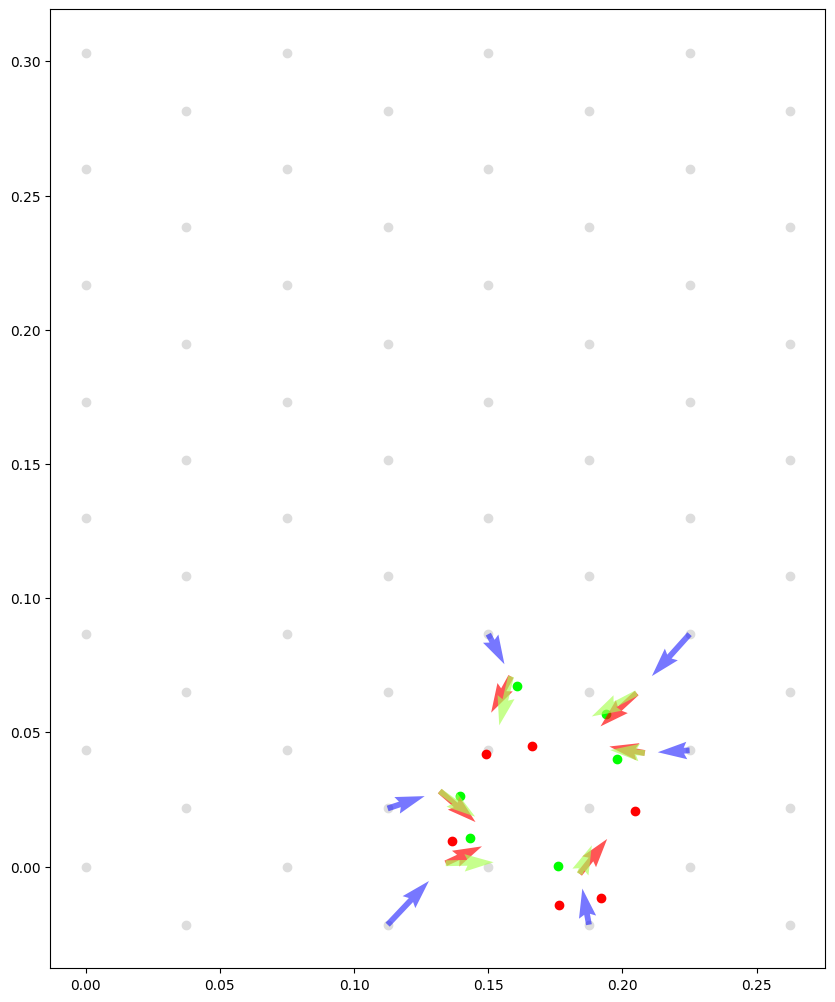

[[ 0.0225  0.0083]
 [ 0.0203 -0.0157]
 [ 0.0114 -0.0133]
 [ 0.0169  0.0221]
 [-0.0253  0.0207]]
[[ 0.0234  0.0005]
 [ 0.0161 -0.0145]
 [ 0.0018 -0.0126]
 [ 0.0127  0.0194]
 [-0.0229  0.0153]]
5


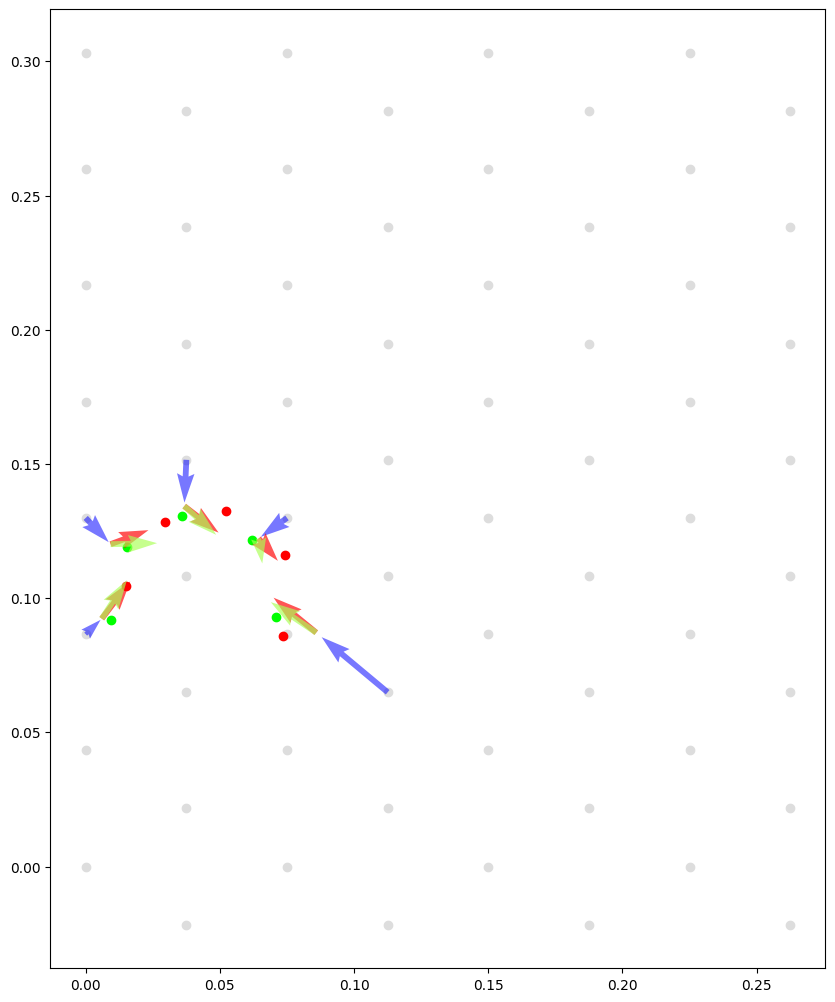

[[-0.0271  0.0297]
 [ 0.0279  0.0298]
 [-0.0296  0.0232]
 [ 0.0224 -0.0264]
 [ 0.0296 -0.0214]
 [ 0.0299  0.0219]]
[[-0.0338  0.0479]
 [ 0.0552  0.0618]
 [-0.0436  0.0123]
 [ 0.0212 -0.0336]
 [ 0.0595 -0.0261]
 [ 0.0755  0.0204]]
6


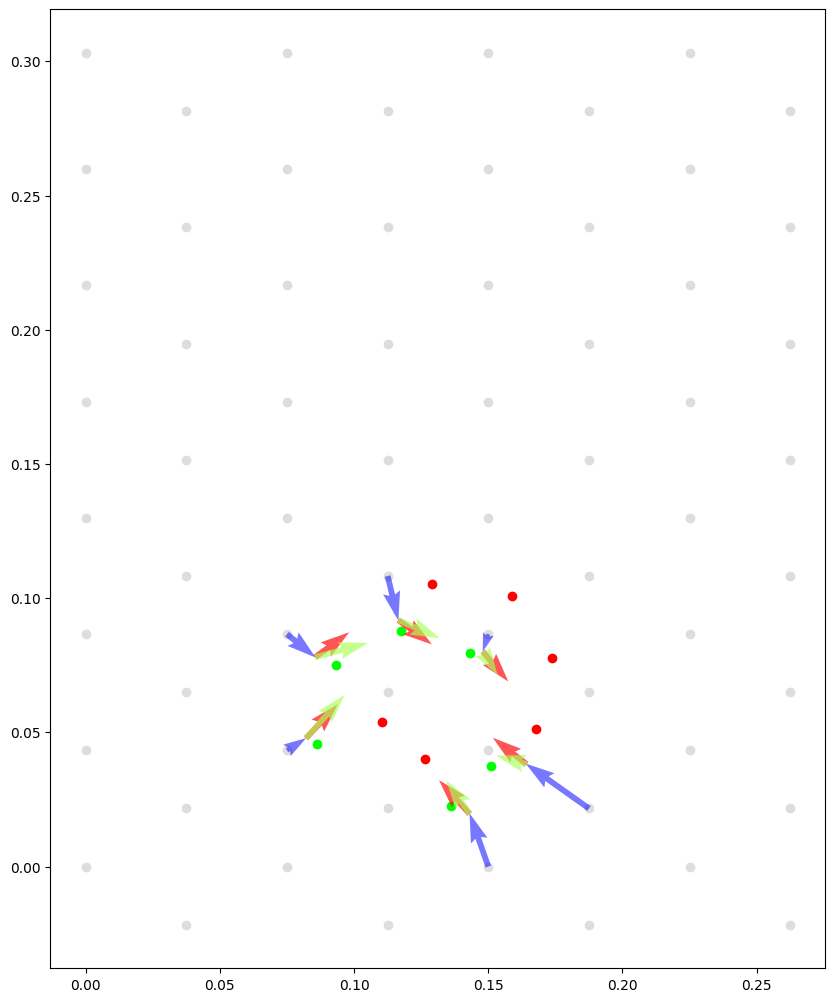

[[ 2.9618e-02  2.7669e-02]
 [-3.6015e-06  1.8855e-02]
 [-2.9649e-02 -2.4605e-02]
 [-2.9195e-02  1.4677e-02]
 [ 2.3350e-02 -2.9425e-02]
 [-2.4121e-02  2.9380e-02]]
[[ 0.0533  0.0179]
 [ 0.0164  0.0627]
 [-0.0624 -0.0347]
 [-0.0639 -0.0071]
 [ 0.0097 -0.0627]
 [-0.0319  0.0467]]
6


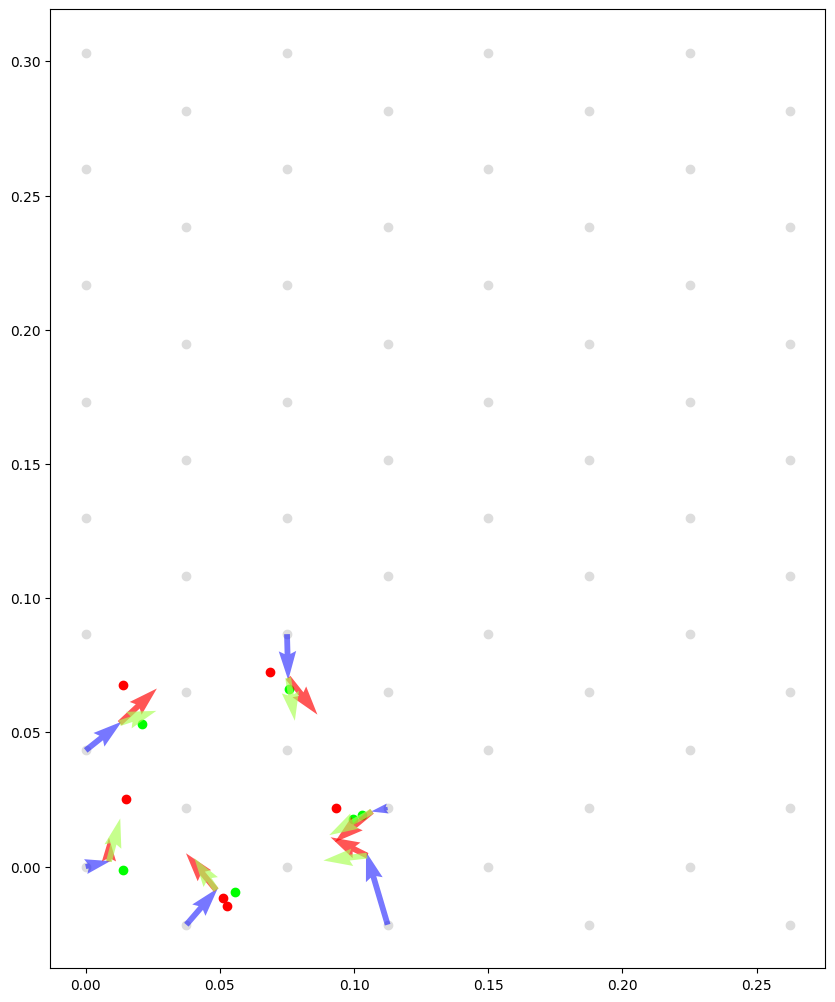

[[ 0.0298 -0.0284]
 [-0.0284  0.0286]
 [ 0.0112  0.0299]
 [ 0.0296  0.0298]
 [ 0.03    0.0031]
 [ 0.0235  0.03  ]]
[[ 0.0729 -0.0403]
 [-0.0366  0.0412]
 [ 0.0077  0.0821]
 [ 0.0742  0.084 ]
 [ 0.1067 -0.006 ]
 [ 0.0298  0.1201]]
6


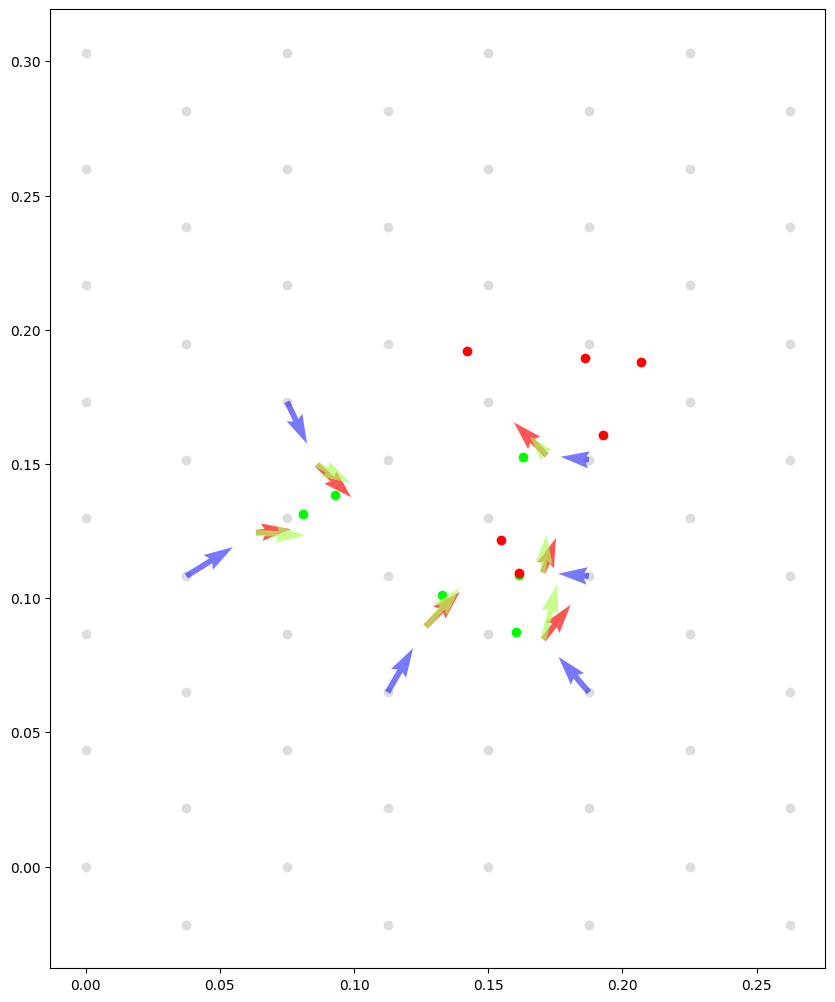

[[ 0.0283 -0.027 ]
 [-0.0017  0.0297]
 [ 0.0211  0.0296]
 [-0.0299  0.015 ]
 [-0.0289 -0.0297]
 [ 0.0286 -0.0297]]
[[ 0.0404 -0.0416]
 [ 0.0032  0.0524]
 [ 0.0231  0.0581]
 [-0.0718  0.005 ]
 [-0.0472 -0.0689]
 [ 0.0419 -0.0792]]
6


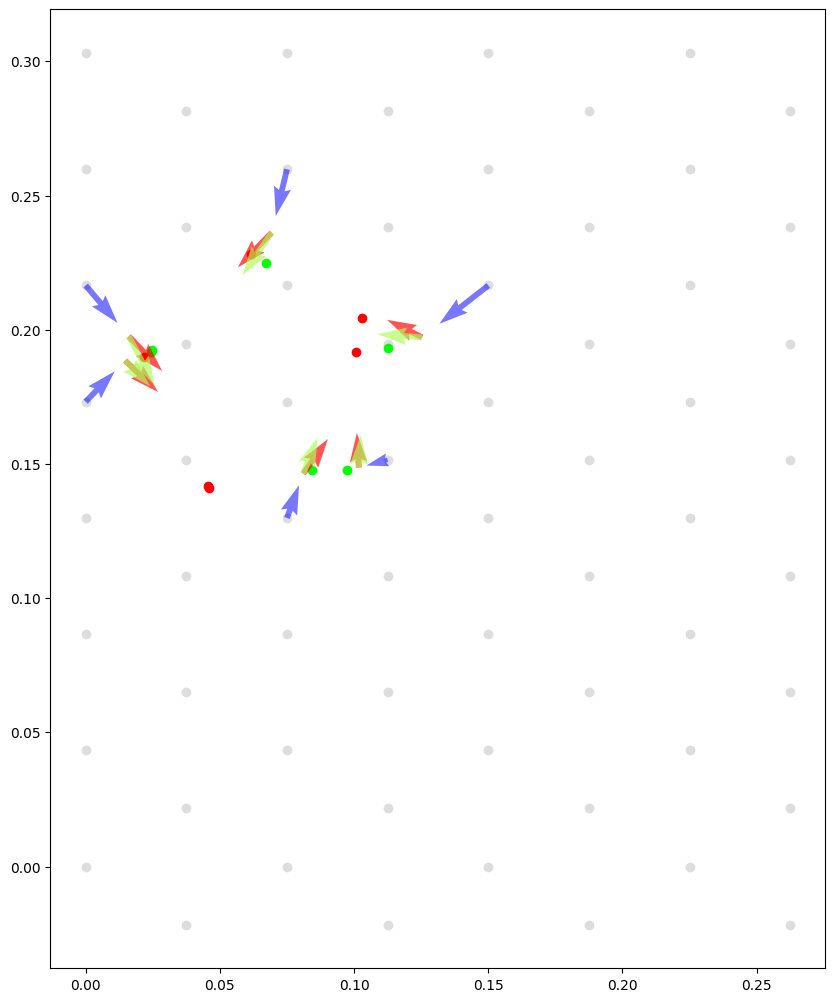

[[ 0.0095  0.014 ]
 [-0.0289  0.016 ]
 [-0.028  -0.0257]
 [ 0.0163 -0.0295]
 [-0.0291 -0.0172]
 [-0.0237 -0.0272]
 [ 0.006  -0.0049]]
[[ 0.0049  0.0079]
 [-0.0349  0.0089]
 [-0.0358 -0.0276]
 [ 0.0108 -0.0497]
 [-0.0366 -0.0178]
 [-0.027  -0.0383]
 [-0.0008 -0.0041]]
7


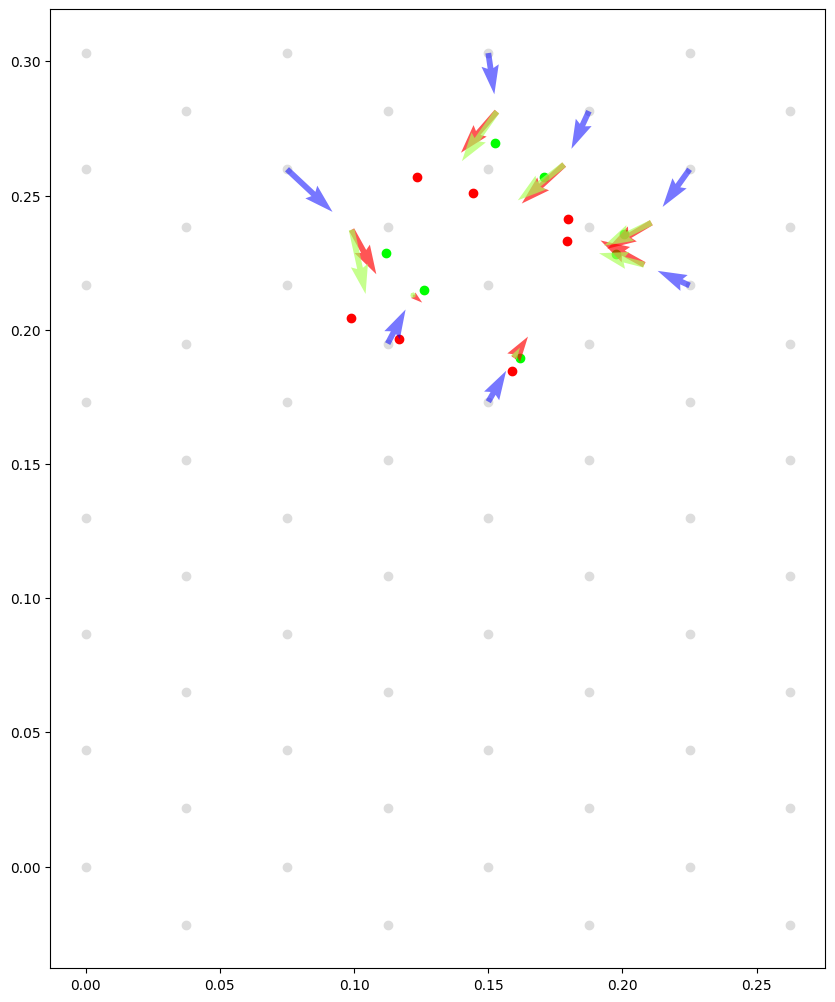

[[ 0.0288  0.0238]
 [ 0.0205  0.0028]
 [-0.0289  0.0298]
 [-0.0297 -0.0283]
 [-0.0298  0.0012]
 [ 0.0239  0.0299]]
[[ 0.0449  0.03  ]
 [ 0.0203  0.0048]
 [-0.0417  0.0676]
 [-0.059  -0.0258]
 [-0.064   0.0077]
 [ 0.025   0.0831]]
6


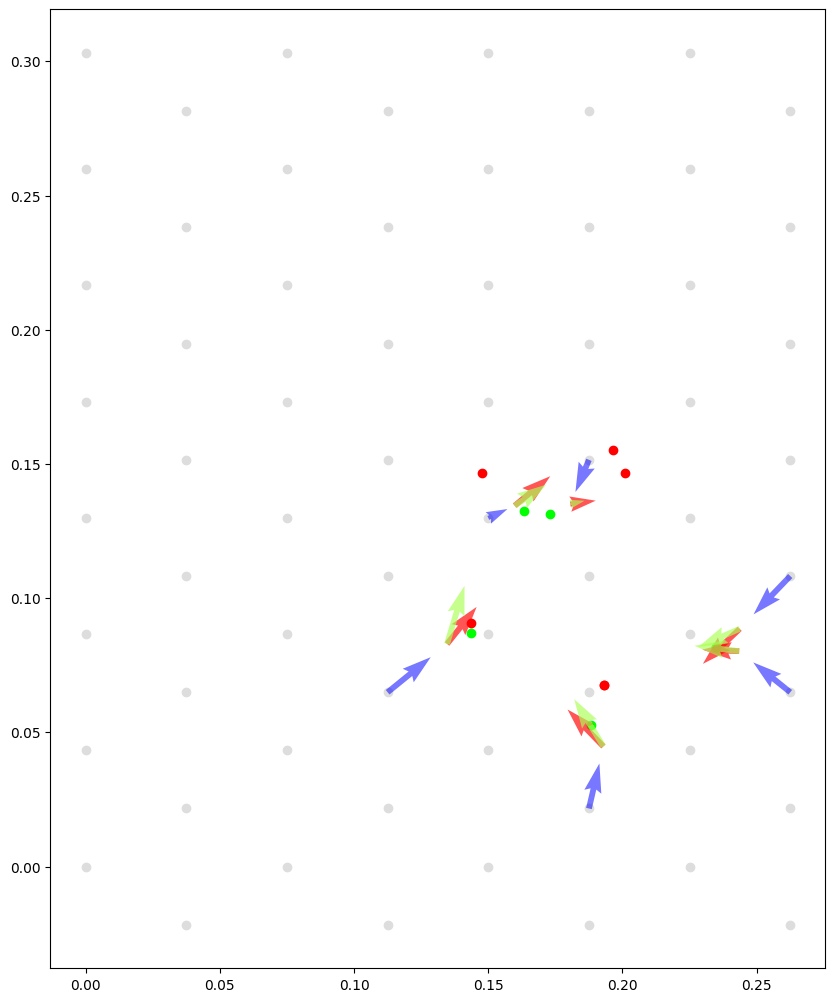

[[ 0.0075 -0.0267]
 [-0.0292  0.0299]
 [-0.0284 -0.0165]
 [ 0.0232  0.0082]
 [-0.0298  0.0059]
 [-0.0295  0.0281]]
[[ 0.009  -0.0293]
 [-0.0627  0.0667]
 [-0.0487 -0.0206]
 [ 0.021   0.0112]
 [-0.0739 -0.0044]
 [-0.0624  0.0297]]
6


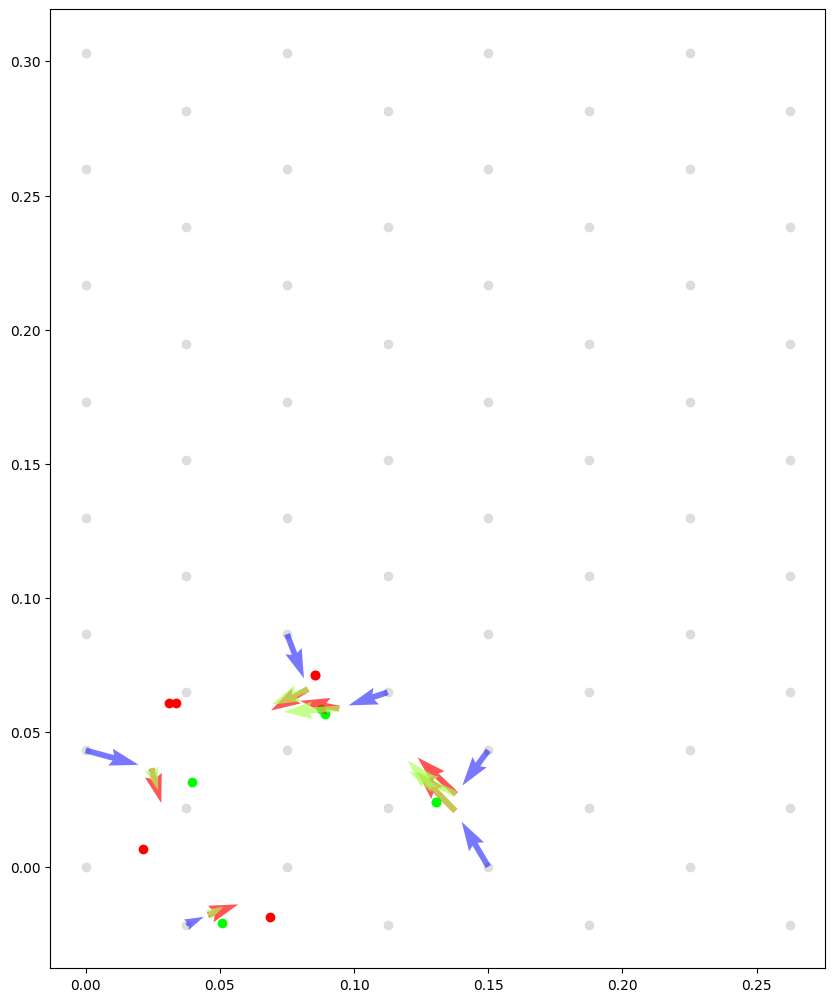

[[-0.0245 -0.0285]
 [-0.0169  0.028 ]
 [-0.0293  0.0279]
 [ 0.0283 -0.0237]]
[[-0.0394 -0.0445]
 [-0.0157  0.0365]
 [-0.047   0.0282]
 [ 0.0395 -0.0262]]
4


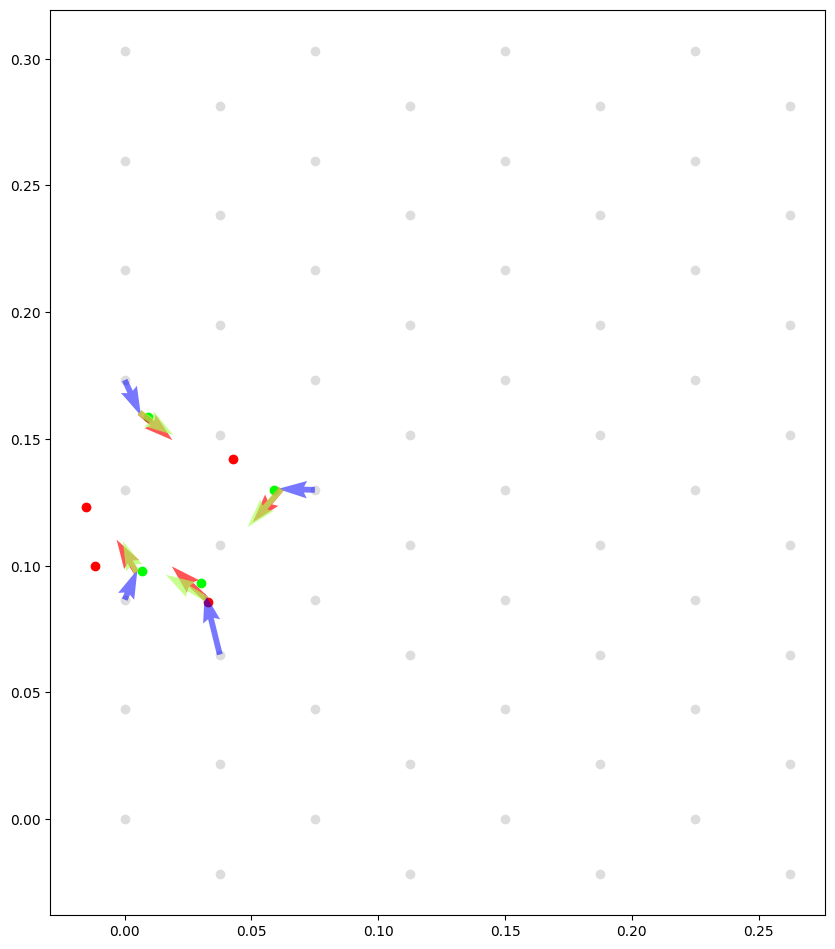

[[ 0.0236  0.0296]
 [-0.0183  0.007 ]
 [-0.0202  0.0283]
 [ 0.0216  0.0145]
 [ 0.0254  0.0224]
 [-0.0193 -0.018 ]
 [ 0.0215  0.0274]]
[[ 0.017   0.0496]
 [-0.0118  0.0061]
 [-0.0116  0.0378]
 [ 0.0152  0.0086]
 [ 0.0243  0.0168]
 [-0.0138 -0.0093]
 [ 0.0153  0.0352]]
7


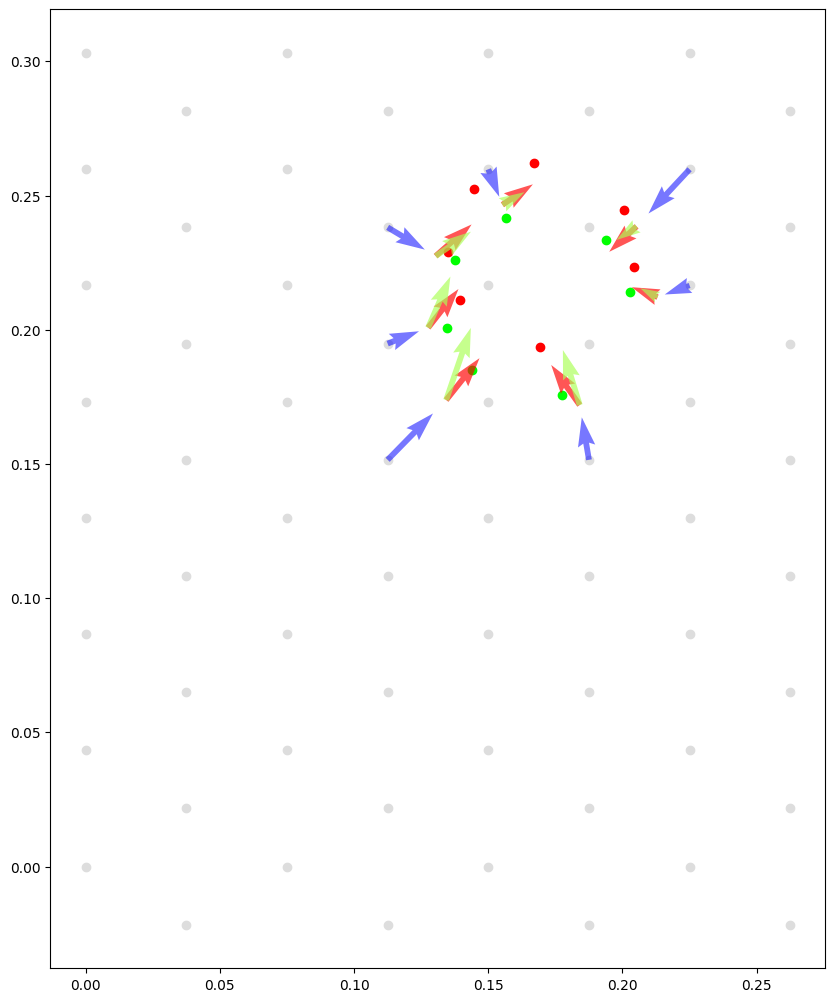

[[ 0.0279 -0.0252]
 [-0.0265  0.0179]
 [-0.0082 -0.0265]
 [ 0.0289  0.0184]
 [ 0.0197  0.0292]
 [ 0.018  -0.0255]]
[[ 0.0389 -0.0344]
 [-0.0309  0.0113]
 [-0.0105 -0.0313]
 [ 0.0425  0.0025]
 [ 0.013   0.0405]
 [ 0.0101 -0.0384]]
6


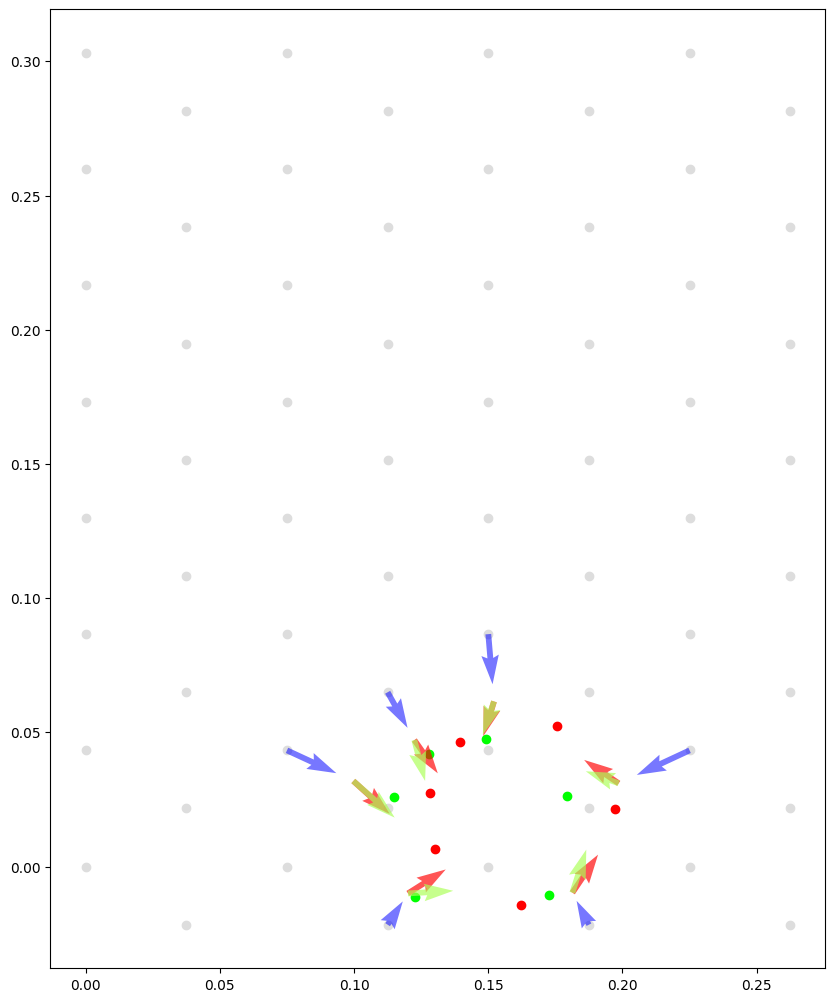

In [18]:
losses = []
for n, (state, action, action_gt, pos, N) in enumerate(zip(statesss, actionsss, actions_gt, possss, n_agents)):
    state, action, action_gt, pos = state, action, action_gt, pos
    pos = pos.squeeze(2).detach().cpu().numpy()
    acts = action.detach().cpu().numpy()
    acts_gt = action_gt.detach().cpu().numpy()
    state = state.detach().cpu().numpy()


    # state = state_scaler.inverse_transform(state)
    # acts = action_scaler.inverse_transform(acts)
    # acts_gt = action_scaler.inverse_transform(act_gt)

    for n, idx in enumerate(range(state.shape[0])):
    # idx = 0
        po = pos[idx]
        r_poses = kdtree_positions_world[po[:N]]
        init_pts = state[idx][:N,:2] + r_poses
        goal_bd_pts = state[idx][:N,2:4] + r_poses
        act_grsp = state[idx][:N,4:6]
        act = acts[idx]
        print(act)
        act_gt = acts_gt[idx, :N]
        print(act_gt)
        r_poses2 = r_poses + act_grsp

        losses.append(np.linalg.norm(act - act_gt))
        # acts = acts/np.linalg.norm(acts, axis=1).reshape(-1, 1)
        # act_gt = act_gt/np.linalg.norm(act_gt, axis=1).reshape(-1, 1)


        print(N)
        plt.figure(figsize=(10,17.78))
        plt.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#ddddddff')
        plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
        plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')

        plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], color='#0000ff88')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:, 0], act[:, 1], color='#ff0000aa')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt[:, 0], act_gt[:, 1], color='#aaff55aa')

        plt.gca().set_aspect('equal')
        plt.show()
        if n%30 == 0:
            break

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Dummy function to simulate pretrained diffusion model
def diffusion_model(state):
    # Generates dummy actions conditioned on state
    return np.sin(state) + np.random.normal(scale=0.1, size=state.shape)

# Dummy function to compute the score function for the actions
def compute_score_function(actions):
    # Compute a dummy score function for visualization
    return np.gradient(actions, axis=0)

# Example data
num_samples = 100
state_dim = 3  # Example state dimension
states = np.linspace(-10, 10, num_samples).reshape(-1, 1) * np.ones((1, state_dim))

# Generate actions using the pretrained diffusion model
actions = diffusion_model(states)

# Compute the score function for the actions
score_function = compute_score_function(actions)

# Create a 3D plot of the score function
fig = go.Figure()

for i in range(state_dim):
    # Add traces for each dimension of the score function
    fig.add_trace(go.Scatter3d(
        x=states[:, 0],
        y=actions[:, i],
        z=score_function[:, i],
        mode='lines',
        name=f'Score Dimension {i+1}',
        line=dict(width=4)
    ))

# Customize the layout for better presentation
fig.update_layout(
    title='3D Visualization of the Score Function',
    scene=dict(
        xaxis_title='State',
        yaxis_title='Action',
        zaxis_title='Score'
    ),
    legend=dict(x=0.1, y=0.9)
)

# Show the plot
fig.show()


In [ ]:
# BYOL for learning robot idx embeddings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    indices = torch.randint(0, num_embeddings, (batch_size,))  # Batch size of 32

    # "View 1" is just the embedding
    embedding1 = model(indices)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,))) % num_embeddings  # Ensure it wraps around at the max integer
    embedding2 = model(indices_2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
n_values = torch.arange(64)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

In [ ]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [ ]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
